# Model Comparison

In this notebook we will create several new subreddit prediction models and systematically compare them.

While looking at new models we want to answer the following questions:
- What auxiliary information is important?
- Are different tokenizers better?
- How many words are needed in our Bag-of-Words?
- Do different classification algorithms (XGBoost, Support Vector Machine, Multinomial Logistic Regression, Random Forest)?
- Do more advanced embedding algorithms such as Averaged Word2Vec or Doc2Vec work better?

In order to make this process smoother, I have created custom classes which will hold the models and the results of our progress. These classes are defined in a seperate notebook which will be periodically updating while I'm working on this notebook. Because of this I will define an UPDATE function which will update objects of the main class. This will also include loading previously recorded data.

Obviously the first thing we have to do is load the reddit data.

In [1]:
import copy

import pandas as pd

df_raw = pd.read_csv('reddit_data2.csv')
df_raw

,id,title,subreddit
0,111kv11,just a typical american doing his thing,funny
1,111ksuo,Someone’s feeling sad after breaking his favor...,funny
2,111kr2e,No Super Bowl halftime show till top this one.,funny
3,111kg8e,"No officer, it's just my air freshener I swear!",funny
4,111kbki,Stinky tonail for a chihuahua,funny
...,...,...,...
9068,10yidw3,AITA for telling my brother that I want an apo...,AmItheAsshole
9069,10yi0qp,WIBTA for not attending a wedding after RSVPin...,AmItheAsshole
9070,10yhzwp,AITA for wanting mom to stay with me away from...,AmItheAsshole
9071,10yhujn,AITA for telling my friend her family is emoti...,AmItheAsshole


In order to make this process smoother, I have created custom classes which will hold the models and the results of our progress. Let's run this seperate notebook and instantiate an object of that class. We will also add the reddit data at this stage.

In [2]:
#Run the other Notebook
%run Classes.ipynb

#Instantiate a new object and load the Reddit Data
obj = Subreddit_Predictor()
obj.add_data(df_raw)
obj.ready_data()

In [3]:
obj.full_data

,title,subreddit,subreddit_num
id,,,
111kv11,just a typical american doing his thing,funny,5
111ksuo,Someone’s feeling sad after breaking his favor...,funny,5
111kr2e,No Super Bowl halftime show till top this one.,funny,5
111kg8e,"No officer, it's just my air freshener I swear!",funny,5
111kbki,Stinky tonail for a chihuahua,funny,5
...,...,...,...
10yidw3,AITA for telling my brother that I want an apo...,AmItheAsshole,0
10yi0qp,WIBTA for not attending a wedding after RSVPin...,AmItheAsshole,0
10yhzwp,AITA for wanting mom to stay with me away from...,AmItheAsshole,0


Next we load all of the data we previously had access to in the Preliminary Assessment notebook.

In [4]:
import pickle as pkl

#Load the Results Data from the Naive model and the Human Guessing `model'
with open ("human_results2.pkl", 'rb') as f:
    data = pkl.load(f)
obj.Results.loc['Human'] = data

with open ("naive_results2.pkl", 'rb') as f:
    data = pkl.load(f)
obj.Results.loc['Naive'] = data

with open ("naive_results_mean2.pkl", 'rb') as f:
    data = pkl.load(f)
obj.Cross_Validation_Results_avg.loc['Naive'] = data

with open ("naive_results_std2.pkl", 'rb') as f:
    data = pkl.load(f)
obj.Cross_Validation_Results_std.loc['Naive'] = data

This allows us to compare the results of our new models with both the Naive Model we produced earlier and the Human Guessing results as well.

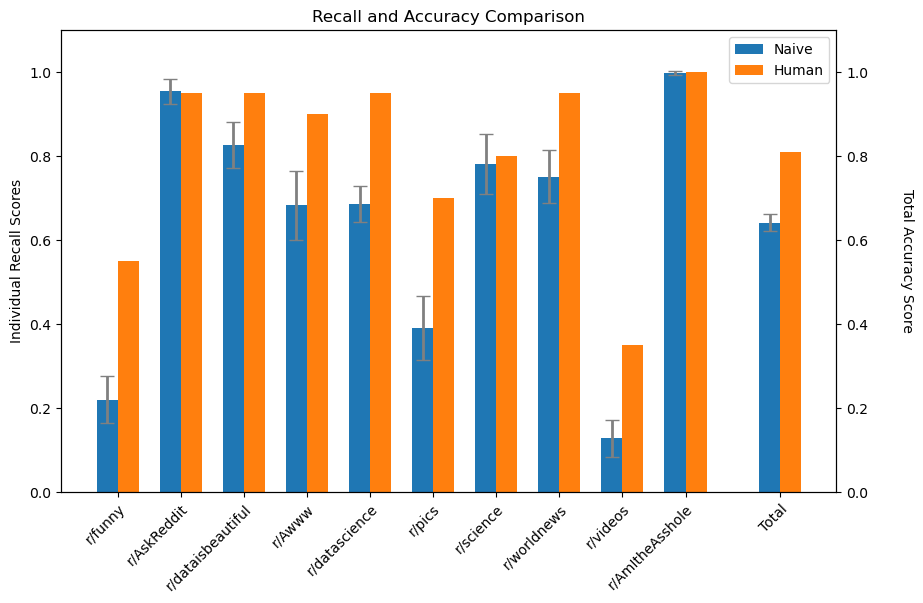

In [5]:
obj.compare([ 'Naive', 'Human'], error_bars=True)

Lastly, since we will be working on editing the Classes.ipynb file at the same time as this file, we will create some functions to help us along the way.

In [6]:
pickleable_attrs = ['raw_data', 'full_data', 'subreddits', 'X_train', 'Y_train', 'X_test', 'Y_test', 'Feature_Vectors',
                    'Models_info', '_le', '_train_index', '_test_index', 'Predictions', 'Results',
                    'Cross_Validation_Results', 'Cross_Validation_Results_avg', 'Cross_Validation_Results_std',
                    'ErrorBars', 'ALL_FEATURES']
nonpickleable_attrs = ['Classifiers', 'Models']


def SAVE_obj(obj, path):
    # Create a dictionary of the object's attributes
    obj_dict = {}
    for attr in pickleable_attrs:
        obj_dict[attr] = obj.__dict__[attr]

    # Save the dictionary to a file
    with open(path, 'wb') as f:
        pkl.dump(obj_dict, f)


def UPDATE_obj(obj, path):
    #Run the other Notebook
    %run Classes.ipynb

    #Instantiate a new object and load the Reddit Data
    new_obj = Subreddit_Predictor()

    # Save the attributes of the old object to a dictionary
    obj_dict = {}
    for attr in pickleable_attrs:
        obj_dict[attr] = obj.__dict__[attr]
        new_obj.__dict__[attr] = obj.__dict__[attr]

    SAVE_obj(new_obj, path)

    for attr in nonpickleable_attrs:
        new_obj.__dict__[attr] = obj.__dict__[attr]

    return new_obj


def LOAD_obj(path):
    # Load the dictionary from a file
    with open(path, 'rb') as f:
        obj_dict = pkl.load(f)

    # Instantiate a new object
    new_obj = Subreddit_Predictor()

    # Add the attributes from the dictionary to the new object
    for attr, value in obj_dict.items():
        new_obj.__dict__[attr] = value

    return new_obj


In [7]:
path = 'obj2.pkl'
SAVE_obj(obj, path)

In [8]:
obj = UPDATE_obj(obj, path)

## Feature Engineering

In [9]:
import re

df = obj.ALL_FEATURES.copy()

df['Aux: num_chars'] = df['title'].apply(lambda x: len(x))
df['Aux: num_caps'] =df['title'].apply(lambda s: len(re.findall(r'[A-Z]', s)))
df['Aux: num_lower'] = df['title'].apply(lambda s: len(re.findall(r'[a-z]', s)))
df['Aux: num_emojis'] = df['title'].apply(lambda s: len(re.findall(
        r'[\u2600-\u27bf]' # Miscellaneous Symbols and Pictographs (☀️, 🌁, 🌊)
        r'|[\U0001f300-\U0001f5ff]' # Emoticons (🌞, 🌝, 🌚)
        r'|[\U0001f600-\U0001f64f]' # Transport and Map Symbols (🚗, 🚕, 🚆)
        r'|[\U0001f680-\U0001f6ff]' # Transport and Map Symbols (🚁, 🚲, 🛴)
        r'|[\u2b00-\u2bff]' # Additional emoticons (⬛, ❤️, 🔥)
        , s)))

obj.ALL_FEATURES = df
obj.ALL_FEATURES

,title,subreddit,subreddit_num,Aux: num_chars,Aux: num_caps,Aux: num_lower,Aux: num_emojis
id,,,,,,,
111kv11,just a typical american doing his thing,funny,5,39,0,33,0
111ksuo,Someone’s feeling sad after breaking his favor...,funny,5,53,1,44,0
111kr2e,No Super Bowl halftime show till top this one.,funny,5,46,3,34,0
111kg8e,"No officer, it's just my air freshener I swear!",funny,5,47,2,34,0
111kbki,Stinky tonail for a chihuahua,funny,5,29,1,24,0
...,...,...,...,...,...,...,...
10yidw3,AITA for telling my brother that I want an apo...,AmItheAsshole,0,77,5,56,0
10yi0qp,WIBTA for not attending a wedding after RSVPin...,AmItheAsshole,0,143,9,109,0
10yhzwp,AITA for wanting mom to stay with me away from...,AmItheAsshole,0,51,4,36,0


In [10]:
from collections import Counter


# Create a list of all characters in the title column

training = pd.DataFrame(obj.X_train)

all_characters = ''.join(training['title'])
total_chars = len(all_characters)

# Create a Counter object to count the occurrences of each word
character_count = Counter(all_characters)
# Create a list of words that appear more than 100 times
infrequent_chars = [char for char, count in character_count.items() if ((count < total_chars/100) & (count > 10))]
#infrequent_chars = [char for char, count in character_count.items() if (count > 10)]

# Print the list of frequent words
print(infrequent_chars)

["'", 'v', '/', 'Y', 'T', '?', 'I', 'k', '’', 'W', 'R', ',', 'A', 'x', '[', 'O', 'C', ']', '5', '.', 'N', 'E', 'D', 'B', 'L', 'M', 'F', 'G', 'H', 'K', 'U', 'V', 'S', '!', 'z', 'j', 'q', '-', '…', 'P', '1', '9', '6', '8', '0', '4', 'J', '2', '|', '"', '(', ')', ':', '&', '‘', '3', 'Z', '*', '—', '7', 'Q', 'X', '+', '“', '”', '🥰', '️', '$', '😂', '–', '%', '#', 'é', '❤', '_', 'ü', '=', '😍', ';', '♥']


In [11]:
df = obj.ALL_FEATURES.copy()

new_cols = {'BoC: ' + str(char): df['title'].apply(lambda x: x.count(char)) for char in infrequent_chars}
df = pd.concat([df, pd.DataFrame(new_cols)], axis = 1)


obj.ALL_FEATURES = df
obj.ALL_FEATURES

,title,subreddit,subreddit_num,Aux: num_chars,Aux: num_caps,Aux: num_lower,Aux: num_emojis,BoC: ',BoC: v,BoC: /,...,BoC: %,BoC: #,BoC: é,BoC: ❤,BoC: _,BoC: ü,BoC: =,BoC: 😍,BoC: ;,BoC: ♥
id,,,,,,,,,,,,,,,,,,,,,
111kv11,just a typical american doing his thing,funny,5,39,0,33,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
111ksuo,Someone’s feeling sad after breaking his favor...,funny,5,53,1,44,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
111kr2e,No Super Bowl halftime show till top this one.,funny,5,46,3,34,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
111kg8e,"No officer, it's just my air freshener I swear!",funny,5,47,2,34,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
111kbki,Stinky tonail for a chihuahua,funny,5,29,1,24,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10yidw3,AITA for telling my brother that I want an apo...,AmItheAsshole,0,77,5,56,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10yi0qp,WIBTA for not attending a wedding after RSVPin...,AmItheAsshole,0,143,9,109,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10yhzwp,AITA for wanting mom to stay with me away from...,AmItheAsshole,0,51,4,36,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
def clean_data(df):
    """
    :param df: Pandas DataFrame with a column 'title'
    :return: original df with the contents of the 'title' column altered. All lowercase. Replace "[oc]", "(oc)", and "[nsfw]" with "_oc_" and "_nsfw_" respectively.
    """

    df['title'] = df['title'].apply(lambda s: s.lower())

    df['title'] = df['title'].apply(lambda s: s.replace("[oc]", "_oc_"))
    df['title'] = df['title'].apply(lambda s: s.replace("(oc)", "_oc_"))
    df['title'] = df['title'].apply(lambda s: s.replace("[nsfw]", "_nsfw_"))
    df['title'] = df['title'].apply(lambda s: s.replace("(nsfw)", "_nsfw_"))
    df['title'] = df['title'].apply(lambda s: s.replace("[wip]", "_wip_"))
    df['title'] = df['title'].apply(lambda s: s.replace("(wip)", "_wip_"))

    return df

In [13]:
import nltk

df = clean_data(obj.ALL_FEATURES)

df['title_tokens'] = df['title'].apply(nltk.word_tokenize)

obj.ALL_FEATURES = df
obj.ALL_FEATURES

,title,subreddit,subreddit_num,Aux: num_chars,Aux: num_caps,Aux: num_lower,Aux: num_emojis,BoC: ',BoC: v,BoC: /,...,BoC: #,BoC: é,BoC: ❤,BoC: _,BoC: ü,BoC: =,BoC: 😍,BoC: ;,BoC: ♥,title_tokens
id,,,,,,,,,,,,,,,,,,,,,
111kv11,just a typical american doing his thing,funny,5,39,0,33,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[just, a, typical, american, doing, his, thing]"
111ksuo,someone’s feeling sad after breaking his favor...,funny,5,53,1,44,0,0,1,0,...,0,0,0,0,0,0,0,0,0,"[someone, ’, s, feeling, sad, after, breaking,..."
111kr2e,no super bowl halftime show till top this one.,funny,5,46,3,34,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[no, super, bowl, halftime, show, till, top, t..."
111kg8e,"no officer, it's just my air freshener i swear!",funny,5,47,2,34,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"[no, officer, ,, it, 's, just, my, air, freshe..."
111kbki,stinky tonail for a chihuahua,funny,5,29,1,24,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[stinky, tonail, for, a, chihuahua]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10yidw3,aita for telling my brother that i want an apo...,AmItheAsshole,0,77,5,56,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[aita, for, telling, my, brother, that, i, wan..."
10yi0qp,wibta for not attending a wedding after rsvpin...,AmItheAsshole,0,143,9,109,0,0,1,0,...,0,0,0,0,0,0,0,0,0,"[wibta, for, not, attending, a, wedding, after..."
10yhzwp,aita for wanting mom to stay with me away from...,AmItheAsshole,0,51,4,36,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[aita, for, wanting, mom, to, stay, with, me, ..."


In [14]:
from nltk.probability import FreqDist

def get_vocab(corpus, tokenizer=nltk.word_tokenize, num_words=False, min_frequency=2):
    """
    :param corpus: a Pandas Series, or other iterable of cleaned text sentences.
    :param tokenizer: a function that takes in a sentence and outputs a list of tokens in that sentence.
    :param num_words: If an integer is given, then this is the max number of words in the vocab.
    :param min_frequency: If an integer is given, then this is the minimum number of times a word must appear in the corpus to be included in the vocab
    :return: A list of all of the tokens in our vocab.
    """
    tokenized_corpus = [tokenizer(corpus.loc[id]['title']) for id in corpus.index]
    flat_list = [word for sublist in tokenized_corpus for word in sublist]
    freq_dist = FreqDist(flat_list)
    vocab = [word for word, freq in freq_dist.items() if freq >= min_frequency]
    if num_words:
        vocab = sorted(vocab, key=lambda x: freq_dist[x], reverse=True)
        vocab = vocab[:min(num_words, len(vocab))]
    vocab.sort()
    return vocab

In [15]:
from tqdm import tqdm

training = clean_data(training)
vocab = get_vocab(training)

df = obj.ALL_FEATURES.copy()
new_cols = {'BoW: ' + word: df['title_tokens'].apply(lambda x: Counter(x)[word]) for word in tqdm(vocab)}
new_df = pd.concat([df, pd.DataFrame(new_cols)], axis=1)
obj.ALL_FEATURES = new_df

obj.ALL_FEATURES

100%|██████████| 6236/6236 [01:46<00:00, 58.51it/s]


,title,subreddit,subreddit_num,Aux: num_chars,Aux: num_caps,Aux: num_lower,Aux: num_emojis,BoC: ',BoC: v,BoC: /,...,BoW: 😍💕,BoW: 😍😍,BoW: 😩,BoW: 🙏,BoW: 🥰,BoW: 🥹,BoW: 🥺,BoW: 🦭,BoW: 🧡,BoW: 🫶🏼
id,,,,,,,,,,,,,,,,,,,,,
111kv11,just a typical american doing his thing,funny,5,39,0,33,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
111ksuo,someone’s feeling sad after breaking his favor...,funny,5,53,1,44,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
111kr2e,no super bowl halftime show till top this one.,funny,5,46,3,34,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
111kg8e,"no officer, it's just my air freshener i swear!",funny,5,47,2,34,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
111kbki,stinky tonail for a chihuahua,funny,5,29,1,24,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10yidw3,aita for telling my brother that i want an apo...,AmItheAsshole,0,77,5,56,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10yi0qp,wibta for not attending a wedding after rsvpin...,AmItheAsshole,0,143,9,109,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10yhzwp,aita for wanting mom to stay with me away from...,AmItheAsshole,0,51,4,36,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
from nltk import pos_tag

df = obj.ALL_FEATURES.copy()

df['pos_tokens'] = df['title_tokens'].apply(lambda x: pos_tag(x))

# Get the list of unique parts of speech
pos_tags = list(set([tag for tokens in df['pos_tokens'] for word, tag in tokens]))

# Add a new column for each part of speech
for pos in tqdm(pos_tags):
    df['PoS: ' + str(pos)] = df['pos_tokens'].apply(lambda x: len([word for word, tag in x if tag == pos]))

obj.ALL_FEATURES = df
obj.ALL_FEATURES


100%|██████████| 43/43 [00:00<00:00, 94.85it/s]


,title,subreddit,subreddit_num,Aux: num_chars,Aux: num_caps,Aux: num_lower,Aux: num_emojis,BoC: ',BoC: v,BoC: /,...,PoS: NN,PoS: PRP$,PoS: CD,PoS: EX,PoS: NNP,PoS: JJS,PoS: VBG,PoS: WP,PoS: FW,PoS: DT
id,,,,,,,,,,,,,,,,,,,,,
111kv11,just a typical american doing his thing,funny,5,39,0,33,0,0,0,0,...,1,1,0,0,0,0,1,0,0,1
111ksuo,someone’s feeling sad after breaking his favor...,funny,5,53,1,44,0,0,1,0,...,4,1,0,0,1,0,2,0,0,0
111kr2e,no super bowl halftime show till top this one.,funny,5,46,3,34,0,0,0,0,...,3,0,1,0,0,0,0,0,0,2
111kg8e,"no officer, it's just my air freshener i swear!",funny,5,47,2,34,0,1,0,0,...,3,1,0,0,0,0,0,0,0,1
111kbki,stinky tonail for a chihuahua,funny,5,29,1,24,0,0,0,0,...,3,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10yidw3,aita for telling my brother that i want an apo...,AmItheAsshole,0,77,5,56,0,0,0,0,...,5,2,0,0,0,0,1,0,0,1
10yi0qp,wibta for not attending a wedding after rsvpin...,AmItheAsshole,0,143,9,109,0,0,1,0,...,5,1,0,0,0,0,3,0,0,3
10yhzwp,aita for wanting mom to stay with me away from...,AmItheAsshole,0,51,4,36,0,0,0,0,...,3,0,0,0,0,0,1,0,0,0


In [17]:
def rename_columns(df):
    new_cols = []
    for col in df.columns:
        new_col = col.replace("[", "open_bracket").replace("]", "close_bracket").replace("<", "less_than")
        new_cols.append(new_col)
    df.columns = new_cols
    return df

obj.ALL_FEATURES = rename_columns(obj.ALL_FEATURES)


In [19]:
import gensim.downloader as api
w2v_model = api.load("word2vec-google-news-300")

In [22]:
def avg_sentence_vector(tokens):

    outside_of_dic = 0
    vectors = []
    for word in tokens:
        try:
            vec = w2v_model[word]
            vectors.append(vec)
        except KeyError:
            # If the word is not in the dictionary, ignore it
            outside_of_dic += 1

    if not vectors:
        # If there are no words in the dictionary, return a vector of zeros
        sentence_vec = np.zeros(w2v_model.vector_size)
    else:
        sentence_vec = np.mean(vectors, axis=0)

    return pd.Series({'W2V_avg': sentence_vec, 'Outside W2V Vocab': outside_of_dic})


def multi_columns(vector):
    return pd.Series({'W2V_avg: ' + str(i + 1): vector[i] for i in range(len(vector))})

In [23]:
df = obj.ALL_FEATURES.copy()

df = df.merge(df['title_tokens'].apply(avg_sentence_vector), left_index=True, right_index=True)#.set_index('id')
df = df.merge(df['W2V_avg'].apply(multi_columns), left_index=True, right_index=True)
obj.ALL_FEATURES = df
obj.ALL_FEATURES


,title,subreddit,subreddit_num,Aux: num_chars,Aux: num_caps,Aux: num_lower,Aux: num_emojis,BoC: ',BoC: v,BoC: /,...,W2V_avg: 291,W2V_avg: 292,W2V_avg: 293,W2V_avg: 294,W2V_avg: 295,W2V_avg: 296,W2V_avg: 297,W2V_avg: 298,W2V_avg: 299,W2V_avg: 300
id,,,,,,,,,,,,,,,,,,,,,
111kv11,just a typical american doing his thing,funny,5,39,0,33,0,0,0,0,...,-0.137736,0.091588,-0.139974,0.043213,-0.139242,-0.014587,0.092326,-0.028361,0.061829,-0.018415
111ksuo,someone’s feeling sad after breaking his favor...,funny,5,53,1,44,0,0,1,0,...,-0.081516,0.065094,-0.096220,-0.020460,-0.051215,-0.107340,-0.020142,-0.031175,0.051731,-0.002918
111kr2e,no super bowl halftime show till top this one.,funny,5,46,3,34,0,0,0,0,...,-0.041734,-0.020226,-0.103753,-0.029080,0.032213,-0.010498,-0.093669,0.000288,-0.050001,-0.100409
111kg8e,"no officer, it's just my air freshener i swear!",funny,5,47,2,34,0,1,0,0,...,-0.006429,0.066406,-0.075765,-0.031867,-0.069343,-0.090719,0.001931,0.012309,-0.024183,-0.059265
111kbki,stinky tonail for a chihuahua,funny,5,29,1,24,0,0,0,0,...,0.011800,0.073832,-0.128743,0.135905,0.015991,-0.039392,-0.090942,0.143392,-0.120117,0.063517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10yidw3,aita for telling my brother that i want an apo...,AmItheAsshole,0,77,5,56,0,0,0,0,...,-0.065574,0.062075,-0.096449,-0.064165,-0.046445,-0.022802,-0.020296,-0.061528,-0.003819,0.006713
10yi0qp,wibta for not attending a wedding after rsvpin...,AmItheAsshole,0,143,9,109,0,0,1,0,...,-0.073010,0.006213,-0.074089,-0.001190,0.041390,0.022414,-0.047607,-0.025467,0.007124,-0.031982
10yhzwp,aita for wanting mom to stay with me away from...,AmItheAsshole,0,51,4,36,0,0,0,0,...,-0.123956,0.131833,-0.171265,-0.058404,-0.053399,-0.011530,-0.017768,-0.010356,0.004801,-0.041083


## Classifiers

In [67]:
from sklearn.linear_model import LogisticRegression

def _LogisticRegression_train(X_train, Y_train):
    # Initialize the logistic regression model
    logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    # Train the model on the input data
    logreg.fit(X_train, Y_train)
    # Output the trained model
    return logreg

def _LogisticRegression_predict(title_vectors, model):
    # Make predictions on the input data
    predictions = model.predict(title_vectors)
    # Output the predictions as a pandas series
    return pd.Series(predictions)

LogReg = Classifier('LogReg')
LogReg._train = _LogisticRegression_train
LogReg._predict = _LogisticRegression_predict
obj.add_classifier(LogReg)

In [25]:
from sklearn import svm

def _SVM_train(X_train, Y_train):
    # Initialize the SVM model
    svm_model = svm.SVC()
    # Train the model on the input data
    svm_model.fit(X_train, Y_train)
    # Output the trained model
    return svm_model

def _SVM_predict(title_vectors, model):
    # Make predictions on the input data
    predictions = model.predict(title_vectors)
    # Output the predictions as a pandas series
    return pd.Series(predictions)

SVM = Classifier('SVM')
SVM._train = _SVM_train
SVM._predict = _SVM_predict
obj.add_classifier(SVM)


In [26]:

from sklearn.ensemble import RandomForestClassifier


def _RandomForest_train(X_train, Y_train):
    # Initialize the Random Forest model
    rf = RandomForestClassifier()
    # Train the model on the input data
    rf.fit(X_train, Y_train)
    # Output the trained model
    return rf


def _RandomForest_predict(title_vectors, model):
    # Make predictions on the input data
    predictions = model.predict(title_vectors)
    # Output the predictions as a pandas series
    return pd.Series(predictions)


RF = Classifier('RF')
RF._train = _RandomForest_train
RF._predict = _RandomForest_predict
obj.add_classifier(RF)


In [27]:
import xgboost as xgb

def _XGBoost_train(X_train, Y_train):
    # Initialize the XGBoost model
    xgb_model = xgb.XGBClassifier()
    # Train the model on the input data
    xgb_model.fit(X_train, Y_train)
    # Output the trained model
    return xgb_model

def _XGBoost_predict(title_vectors, model):
    # Make predictions on the input data
    predictions = model.predict(title_vectors)
    # Output the predictions as a pandas series
    return pd.Series(predictions)

XGB = Classifier('XGB')
XGB._train = _XGBoost_train
XGB._predict = _XGBoost_predict
obj.add_classifier(XGB)


In [28]:
import torch
import pandas as pd

def _NN_train(X_train, Y_train):
    # Convert the input data to tensors
    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    Y_train = torch.tensor(Y_train.values, dtype=torch.long)

    # Initialize the neural network
    input_size = X_train.shape[1]
    hidden_size = 128
    output_size = 10
    net = torch.nn.Sequential(
        torch.nn.Linear(input_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, output_size),
    )

    # Define the loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

    # Train the model
    for epoch in tqdm(range(100)):
        outputs = net(X_train)
        loss = criterion(outputs, Y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return net

def _NN_predict(X_test, model):
    # Convert the input data to tensors
    X_test = torch.tensor(X_test.values, dtype=torch.float32)

    # Make predictions
    with torch.no_grad():
        outputs = model(X_test)
        _, predictions = torch.max(outputs, 1)

    return pd.Series(predictions.numpy())

NN = Classifier("NN")
NN._train = _NN_train
NN._predict = _NN_predict
obj.add_classifier(NN)


In [29]:
import torch
import pandas as pd


def _NN2_train(X_train, Y_train):
    # Convert the input data to tensors
    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    Y_train = torch.tensor(Y_train.values, dtype=torch.long)

    # Initialize the neural network
    input_size = X_train.shape[1]
    hidden_size_1 = 128
    hidden_size_2 = 128
    output_size = 10
    net = torch.nn.Sequential(
        torch.nn.Linear(input_size, hidden_size_1),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size_1, hidden_size_2),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size_2, output_size),
    )

    # Define the loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

    # Train the model
    for epoch in tqdm(range(100)):
        outputs = net(X_train)
        loss = criterion(outputs, Y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return net


def _NN2_predict(X_test, model):
    # Convert the input data to tensors
    X_test = torch.tensor(X_test.values, dtype=torch.float32)

    # Make predictions
    with torch.no_grad():
        outputs = model(X_test)
        _, predictions = torch.max(outputs, 1)

    return pd.Series(predictions.numpy())


NN2 = Classifier("NN2")
NN2._train = _NN2_train
NN2._predict = _NN2_predict
obj.add_classifier(NN2)


## Feature Selection

In [30]:
Aux_features = [col for col in obj.ALL_FEATURES.columns if 'Aux:' in col] + ['Outside W2V Vocab']
BoC_features = [col for col in obj.ALL_FEATURES.columns if 'BoC:' in col]
PoS_features = [col for col in obj.ALL_FEATURES.columns if 'PoS:' in col]
BoW_features = [col for col in obj.ALL_FEATURES.columns if 'BoW:' in col]
W2V_features = [col for col in obj.ALL_FEATURES.columns if 'W2V_avg:' in col]

We will now train the Random Forrest and XGBoost models using the full BoW (about 6000 words). We can then rank the words in order of importance.

In [32]:
obj.new_train_model('RF BoW 6000', BoW_features, 'RF', "A Random Forrest, trained using only the full Bag-of-Words.")
obj.new_test_model('RF BoW 6000')

In [33]:
obj.new_train_model('XGB BoW 6000', BoW_features, 'XGB', "A XGBoost model, trained using only the full Bag-of-Words.")
obj.new_test_model('XGB BoW 6000')

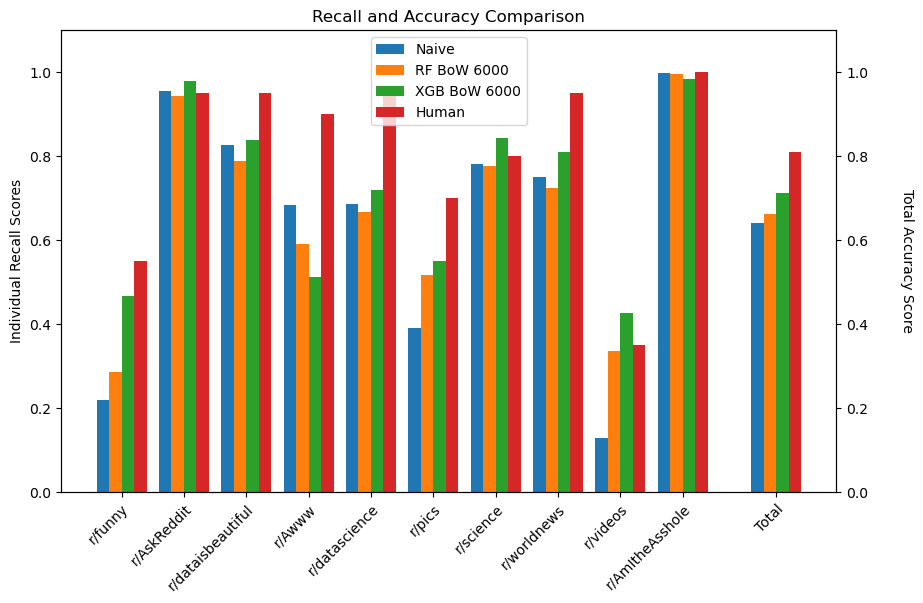

In [37]:
obj.compare(['RF BoW 6000', 'XGB BoW 6000', 'Human'])

In [39]:
# extract the feature importances
importances_rf = obj.Models['RF BoW 6000'].model.feature_importances_

# create a pandas dataframe of the feature importances
importance_df_rf = pd.DataFrame({"feature": BoW_features, "importance": importances_rf})

# sort the dataframe by feature importance
importance_df_rf.sort_values(by="importance", ascending=False, inplace=True)

# print the top 10 most important features
print(importance_df_rf.head(204))

# extract the feature importances
importances_xgb = obj.Models['XGB BoW 6000'].model.feature_importances_

# create a pandas dataframe of the feature importances
importance_df_xgb = pd.DataFrame({"feature": BoW_features, "importance": importances_xgb})

# sort the dataframe by feature importance
importance_df_xgb.sort_values(by="importance", ascending=False, inplace=True)

# print the top 10 most important features
print(importance_df_xgb.head(204))

          feature  importance
351     BoW: aita    0.034294
199        BoW: ?    0.034153
203     BoW: _oc_    0.033211
6050    BoW: what    0.022974
2290     BoW: for    0.017650
...           ...         ...
6061   BoW: while    0.000649
5567   BoW: these    0.000648
5456       BoW: t    0.000642
461   BoW: anyone    0.000640
694     BoW: been    0.000638

[204 rows x 2 columns]
          feature  importance
351     BoW: aita    0.043259
5340   BoW: study    0.024556
6072   BoW: wibta    0.014988
1501    BoW: data    0.014630
203     BoW: _oc_    0.013410
...           ...         ...
5546    BoW: text    0.001132
5240   BoW: state    0.001129
5004    BoW: show    0.001121
1136  BoW: claims    0.001118
3816      BoW: ny    0.001118

[204 rows x 2 columns]


In [41]:
def BoW_top(N):
    lis = list(set(list(importance_df_xgb.sort_values('importance', ascending=False).head(N)['feature']) + list(importance_df_xgb.sort_values('importance', ascending=False).head(N)['feature'])))
    lis.sort()
    return lis

BoW_top(200)


['BoW: !',
 'BoW: #',
 "BoW: '",
 'BoW: -',
 'BoW: 2021',
 'BoW: 2022',
 'BoW: 2023',
 'BoW: ?',
 'BoW: _oc_',
 'BoW: acrylic',
 'BoW: adorable',
 'BoW: advice',
 'BoW: affects',
 'BoW: after',
 'BoW: against',
 'BoW: ai',
 'BoW: aita',
 'BoW: aitah',
 'BoW: alzheimer',
 'BoW: america',
 'BoW: and',
 'BoW: art',
 'BoW: associated',
 'BoW: attack',
 'BoW: average',
 'BoW: baby',
 'BoW: balloon',
 'BoW: bed',
 'BoW: billion',
 'BoW: boy',
 'BoW: brazil',
 'BoW: can',
 'BoW: cancer',
 'BoW: cannabis',
 'BoW: carbon',
 'BoW: cat',
 'BoW: cats',
 'BoW: channel',
 'BoW: chart',
 'BoW: charts',
 'BoW: chatgpt',
 'BoW: china',
 'BoW: chinese',
 'BoW: climate',
 'BoW: could',
 'BoW: countries',
 'BoW: covid-19',
 'BoW: cute',
 'BoW: cutie',
 'BoW: data',
 'BoW: dataset',
 'BoW: david',
 'BoW: difference',
 'BoW: dog',
 'BoW: doggo',
 'BoW: dogs',
 'BoW: ds',
 'BoW: earthquake',
 'BoW: effect',
 'BoW: eu',
 'BoW: evidence',
 'BoW: feb',
 'BoW: flu',
 'BoW: found',
 'BoW: france',
 'BoW: friends'

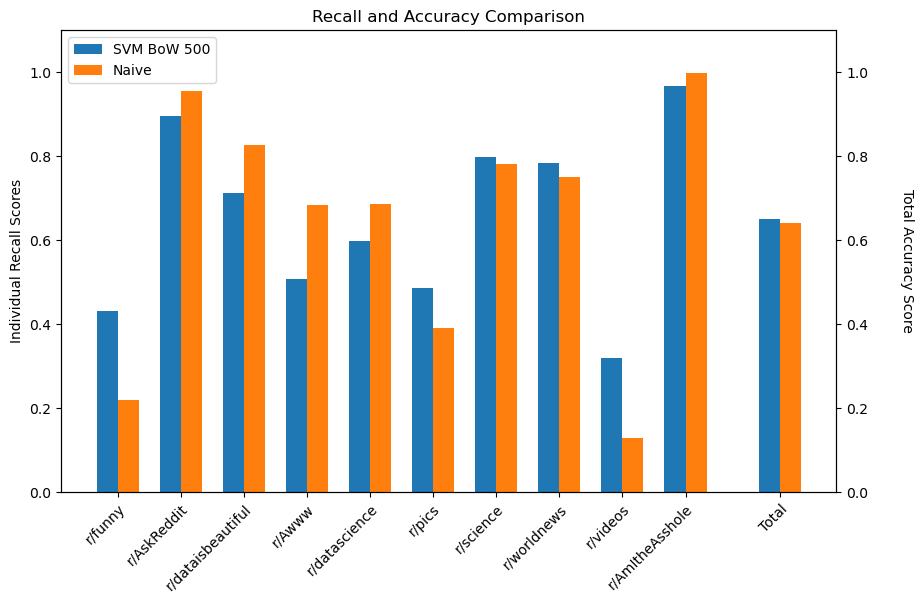

In [44]:
obj.new_train_model('SVM BoW 500', BoW_top(500), 'SVM', "A SVM, trained using only the top 500 words from the Bag-of-Words.")
obj.new_test_model('SVM BoW 500')
obj.compare(['SVM BoW 500', 'Naive'])

We will now train our models on 200, 500, 1000, and 2000 words respectively

In [45]:
N = [200, 500, 1000, 2000]
models = ['LogReg', 'SVM', 'RF', 'XGB']

for n in tqdm(N):
    for mod in tqdm(models):
        model_name = mod + ' BoW ' + str(n)
        obj.new_train_model(model_name, BoW_top(n), mod, description= "A " + str(mod) + " model, trained using only the top " + str(n) + " words from Bag-of-Words.")
        obj.new_test_model(model_name)

  0%|          | 0/4 [00:00<?, ?it/s]C:\Users\raino\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(

  0%|          | 0/4 [00:00<?, ?it/s]C:\Users\raino\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

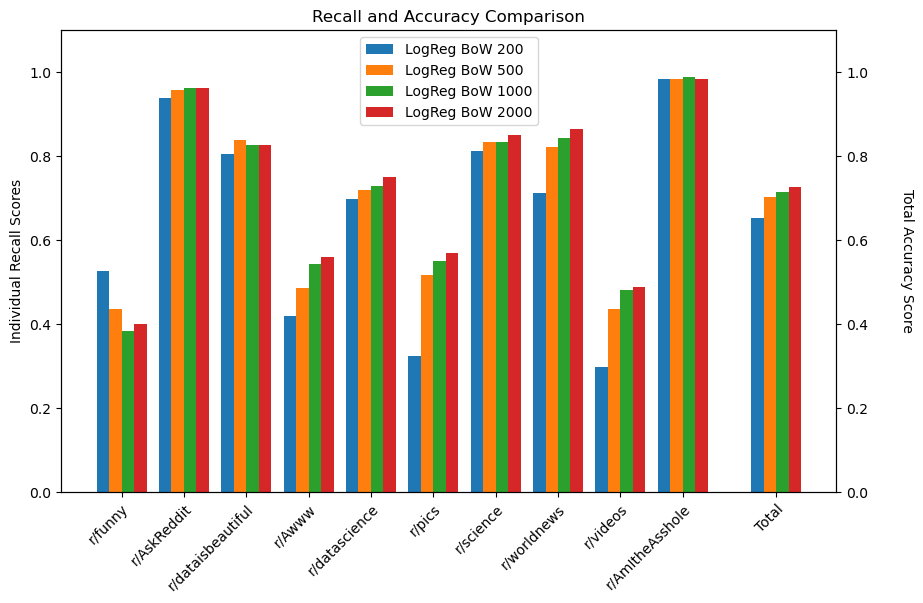

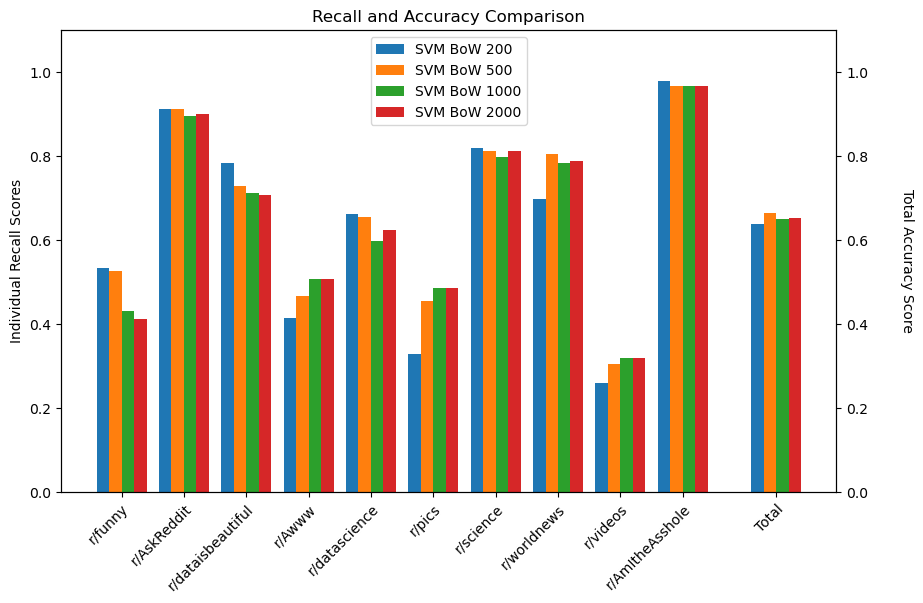

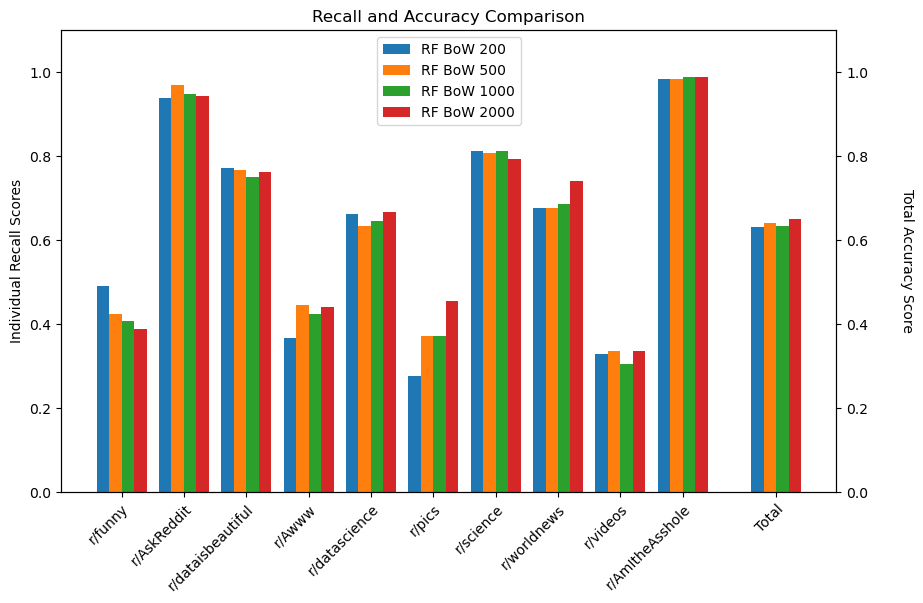

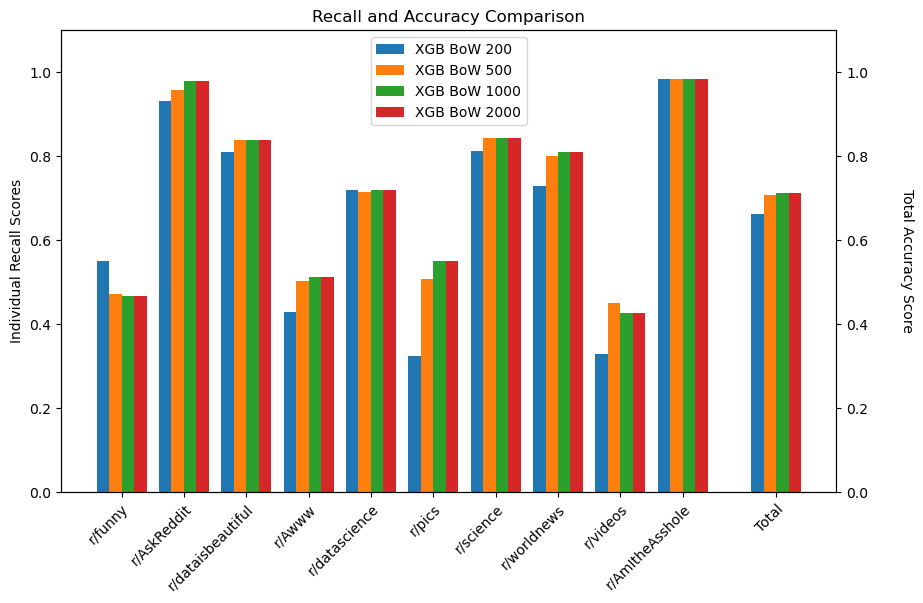

In [46]:
for mod in models:
    mods = []
    for n in N:
        mods.append(mod + ' BoW ' + str(n))
    obj.compare(mods)

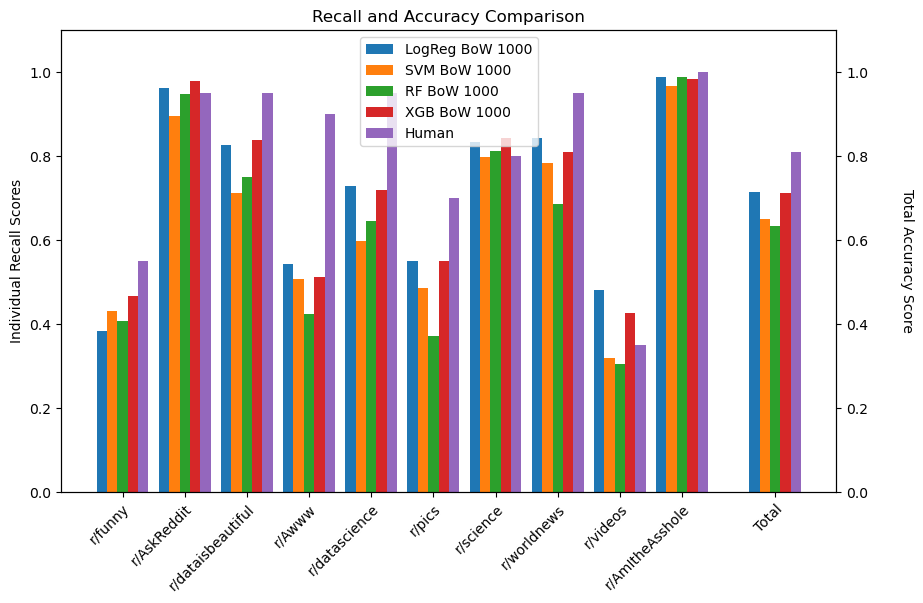

In [48]:
obj.compare([mod + ' BoW 1000' for mod in models] + ['Human'])

Now let's compare to the Word2Vec features

In [49]:
obj.new_train_model('LogReg W2V 300', W2V_features, 'LogReg', "A multinomial Logistic Regression model, trained using only the Word2Vec features.")
obj.new_test_model('LogReg W2V 300')

C:\Users\raino\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [50]:
obj.new_train_model('XGB W2V 300', W2V_features, 'XGB', "An XGB model, trained using only the Word2Vec features.")
obj.new_test_model('XGB W2V 300')

In [51]:
obj.new_train_model('SVM W2V 300', W2V_features, 'SVM', "A SVM model, trained using only the Word2Vec features.")
obj.new_test_model('SVM W2V 300')

In [52]:
obj.new_train_model('RF W2V 300', W2V_features, 'RF', "A RF model, trained using only the Word2Vec features.")
obj.new_test_model('RF W2V 300')

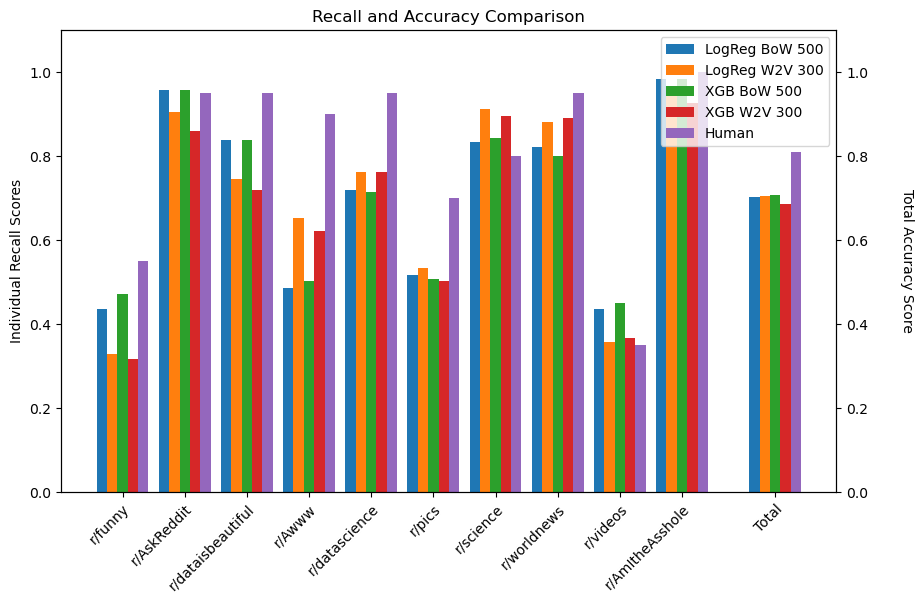

In [57]:
obj.compare(['LogReg BoW 500', 'LogReg W2V 300', 'XGB BoW 500', 'XGB W2V 300', 'Human'])

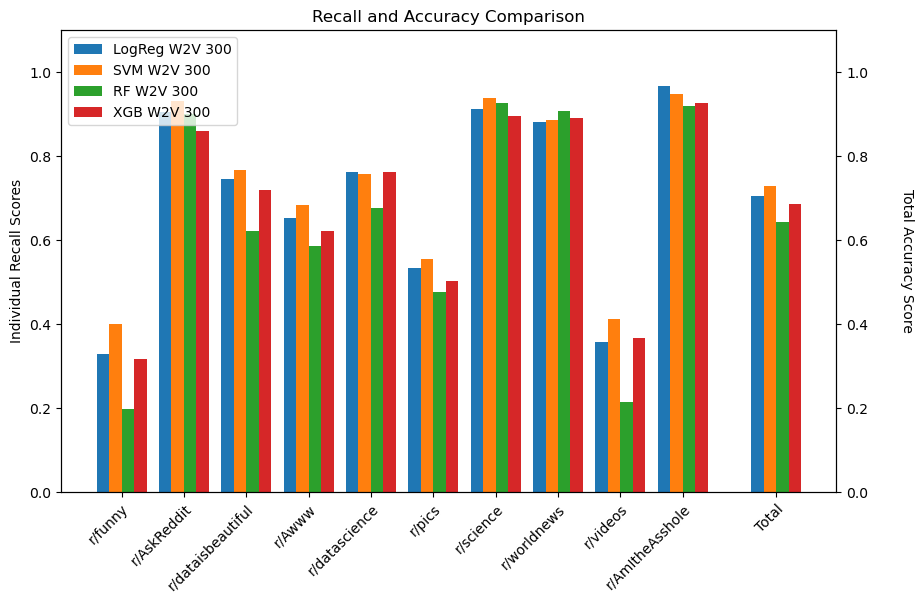

In [58]:
obj.compare(['LogReg W2V 300', 'SVM W2V 300', 'RF W2V 300', 'XGB W2V 300'])

Now let's combind some of our features together

In [59]:
models = ['LogReg', 'SVM', 'RF', 'XGB']
features = W2V_features + BoW_top(500)

for mod in models:
    model_name = mod + " BoW2V 800"
    obj.new_train_model(model_name, features, mod, "A " + mod + " model, trained using both the Word2Vec features and the top 500 words from Bag-of-Words.")
    obj.new_test_model(model_name)

obj.compare([mod + " BoW2V 800" for mod in models ] + ['Human'])

C:\Users\raino\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


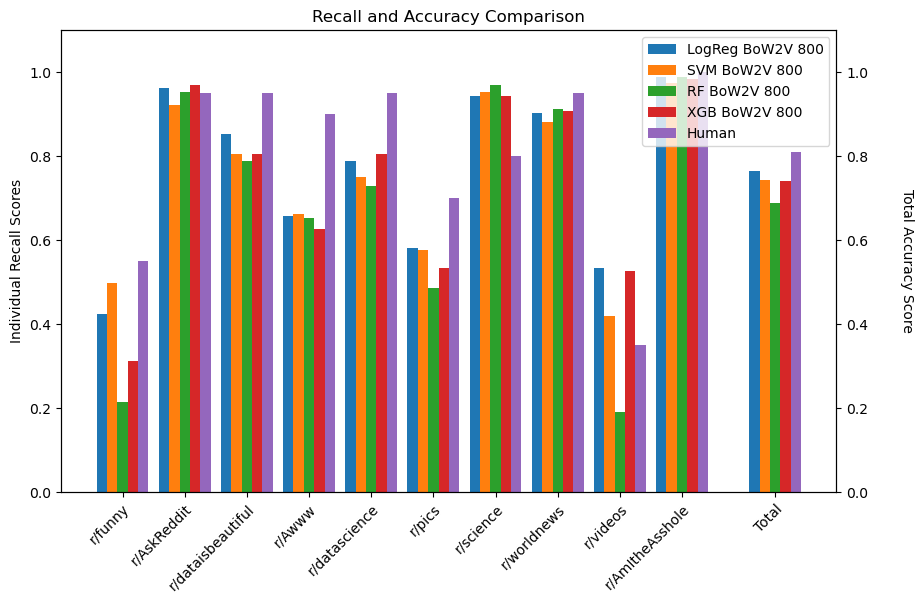

In [66]:
obj.compare([mod + " BoW2V 800" for mod in models ] + ['Human'])

C:\Users\raino\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


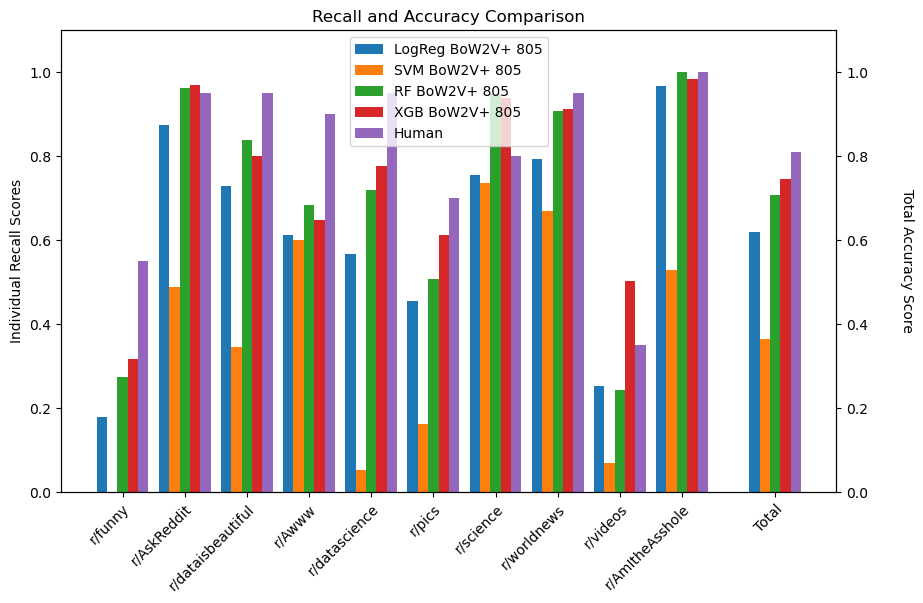

In [64]:
models = ['LogReg', 'SVM', 'RF', 'XGB']
features = W2V_features + BoW_top(500) + Aux_features

suffix = " BoW2V+ " + str(len(features))
for mod in models:
    model_name = mod + suffix
    obj.new_train_model(model_name, features, mod, "A " + mod + " model, trained using both the Word2Vec features and the top 500 words from Bag-of-Words and the auxiliary features.")
    obj.new_test_model(model_name)

obj.compare([mod + suffix for mod in models ] + ['Human'])

C:\Users\raino\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


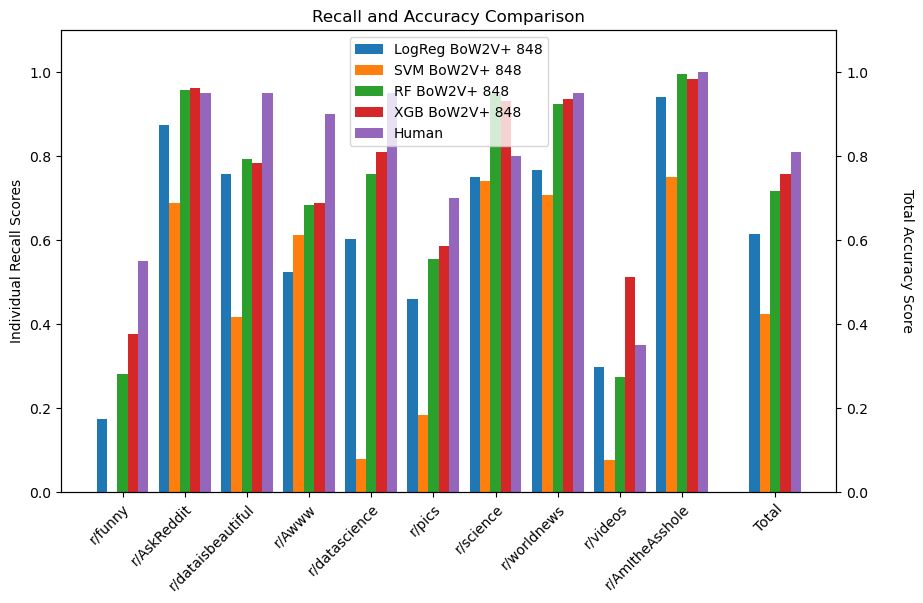

In [65]:
models = ['LogReg', 'SVM', 'RF', 'XGB']
features = W2V_features + BoW_top(500) + Aux_features + PoS_features

suffix = " BoW2V+ " + str(len(features))
for mod in models:
    model_name = mod + suffix
    obj.new_train_model(model_name, features, mod, "A " + mod + " model, trained using both the Word2Vec features and the top 500 words from Bag-of-Words and the auxiliary features.")
    obj.new_test_model(model_name)

obj.compare([mod + suffix for mod in models ] + ['Human'])

In [68]:
mod = 'LogReg'
model_name = mod + suffix
obj.new_train_model(model_name, features, mod, "A " + mod + " model, trained using both the Word2Vec features and the top 500 words from Bag-of-Words and the auxiliary features.")
obj.new_test_model(model_name)

C:\Users\raino\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


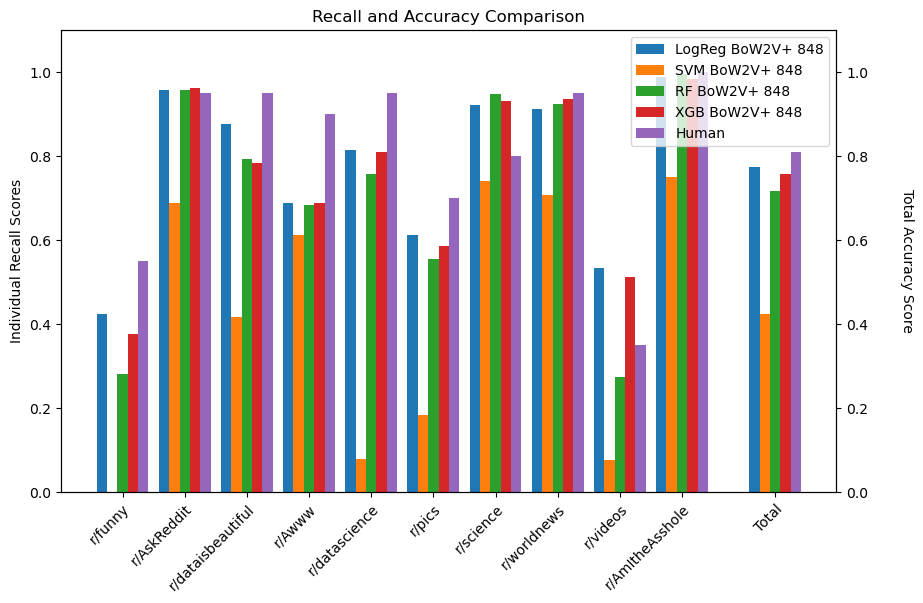

In [69]:
obj.compare([mod + suffix for mod in models ] + ['Human'])

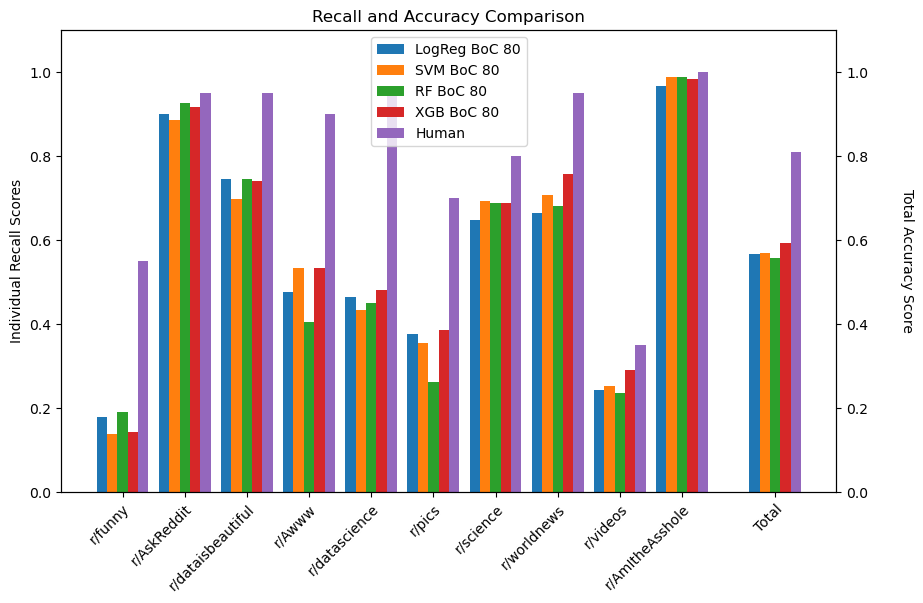

In [70]:
models = ['LogReg', 'SVM', 'RF', 'XGB']
features = BoC_features

suffix = " BoC " + str(len(features))
for mod in models:
    model_name = mod + suffix
    obj.new_train_model(model_name, features, mod, "A " + mod + " model, trained using only the Bag-of-Characters features.")
    obj.new_test_model(model_name)

obj.compare([mod + suffix for mod in models ] + ['Human'])

C:\Users\raino\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


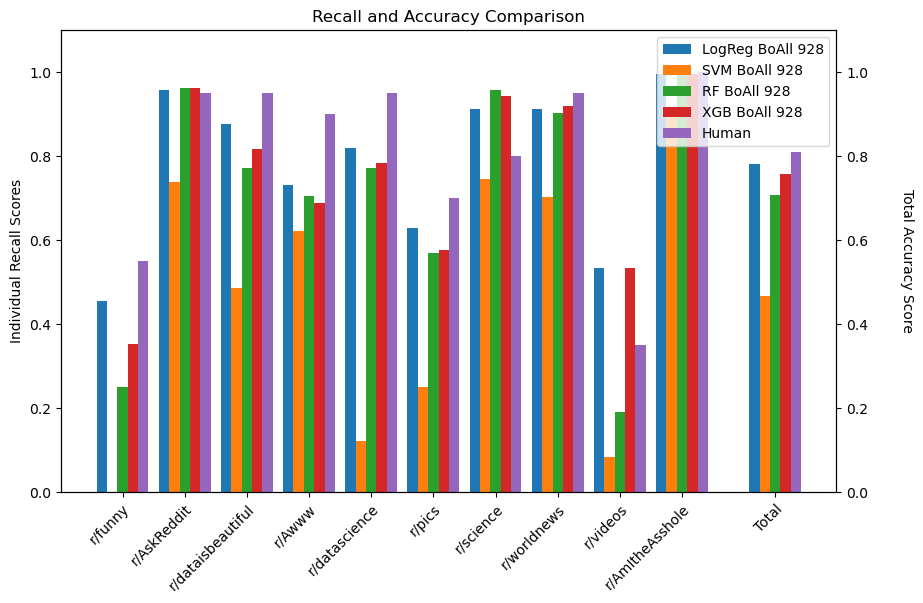

In [72]:
models = ['LogReg', 'SVM', 'RF', 'XGB']
features = W2V_features + BoW_top(500) + Aux_features + PoS_features + BoC_features

suffix = " BoAll " + str(len(features))
for mod in models:
    model_name = mod + suffix
    obj.new_train_model(model_name, features, mod, "A " + mod + " model, trained using the top 500 BoW words and all other features.")
    obj.new_test_model(model_name)

obj.compare([mod + suffix for mod in models ] + ['Human'])

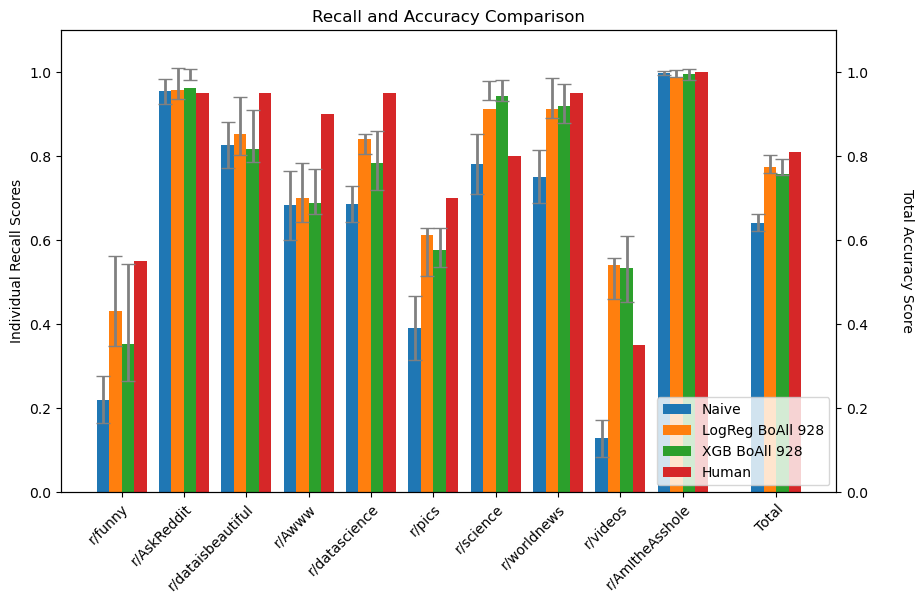

In [87]:
obj.compare(['Naive', 'LogReg BoAll 928', 'XGB BoAll 928', 'Human'], error_bars = True)

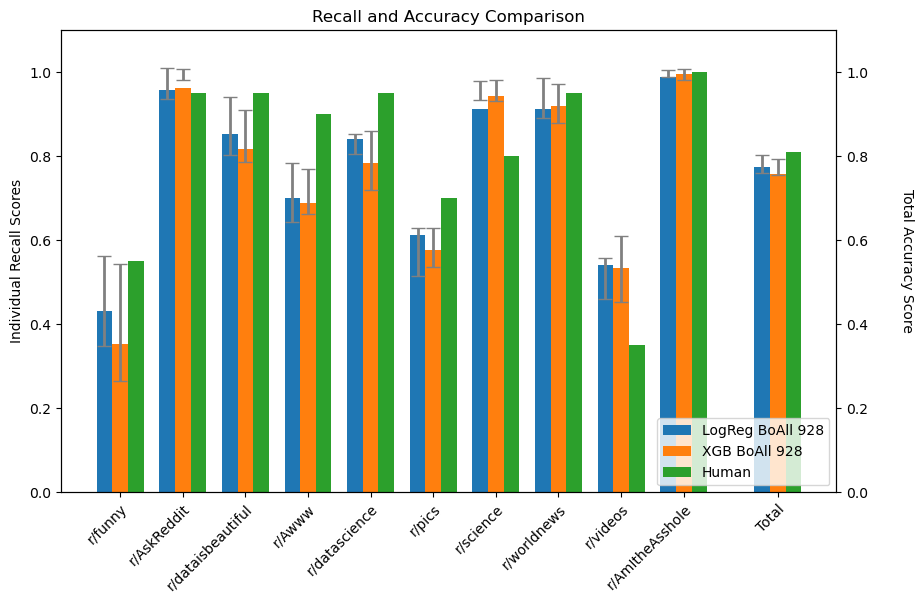

In [88]:
obj.compare(['LogReg BoAll 928', 'XGB BoAll 928', 'Human'], error_bars = True)


In [74]:
obj.new_validate('XGB BoAll 928', 5)

100%|██████████| 5/5 [02:42<00:00, 32.45s/it]


In [106]:
def _LogisticRegression_train2(X_train, Y_train):
    # Initialize the logistic regression model
    logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=4000)
    # Train the model on the input data
    logreg.fit(X_train, Y_train)
    # Output the trained model
    return logreg


def _LogisticRegression_predict2(title_vectors, model):
    # Make predictions on the input data
    predictions = model.predict(title_vectors)
    # Output the predictions as a pandas series
    return pd.Series(predictions)


LogReg2 = Classifier('LogReg2')
LogReg2._train = _LogisticRegression_train2
LogReg2._predict = _LogisticRegression_predict2
obj.add_classifier(LogReg2)

In [84]:
features = W2V_features + BoW_top(500) + Aux_features + PoS_features + BoC_features
obj.new_train_model('LogReg BoAll 928', features, 'LogReg2', "A multinomail logistic regression model, trained using the top 500 BoW words and all other features.")
obj.new_test_model('LogReg BoAll 928')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   42.9s finished


In [86]:
obj.new_validate('LogReg BoAll 928', 5)

  0%|          | 0/5 [00:00<?, ?it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.6s finished
 20%|██        | 1/5 [00:34<02:19, 34.82s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.6s finished
 40%|████      | 2/5 [01:04<01:35, 31.88s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\raino\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = 

In [90]:
# extract the feature importances
importances_xgb = obj.Models['XGB BoAll 928'].model.feature_importances_

# create a pandas dataframe of the feature importances
importance_df_xgb = pd.DataFrame({"feature": features, "importance": importances_xgb})

# sort the dataframe by feature importance
importance_df_xgb.sort_values(by="importance", ascending=False, inplace=True)

# print the top 10 most important features
#print(importance_df_xgb.head(204))

In [99]:
filt = importance_df_xgb['importance'] != 0.0
important_features = list(importance_df_xgb.loc[filt]['feature'])
important_features.sort()
len(important_features)

489

In [102]:
obj.new_train_model('LogReg BoAll- 489', important_features, 'LogReg2', "A multinomail logistic regression model, trained using the top 500 BoW words and all other features, minus all features with an importance score of 0.")
obj.new_test_model('LogReg BoAll- 489')

obj.new_train_model('XGB BoAll- 489', important_features, 'XGB', "An XGB model, trained using the top 500 BoW words and all other features, minus all features with an importance score of 0.")
obj.new_test_model('XGB BoAll- 489')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\raino\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.2s finished


In [104]:
obj.new_validate('LogReg BoAll- 489', 5)
obj.new_validate('XGB BoAll- 489', 5)


  0%|          | 0/5 [00:00<?, ?it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.0s finished
 20%|██        | 1/5 [00:18<01:12, 18.19s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\raino\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.7s finished
 40%|████      | 2/5 [00:37<00:55, 18.61s/it][Parallel(n_jobs=1)]: Using backend SequentialBackend wit

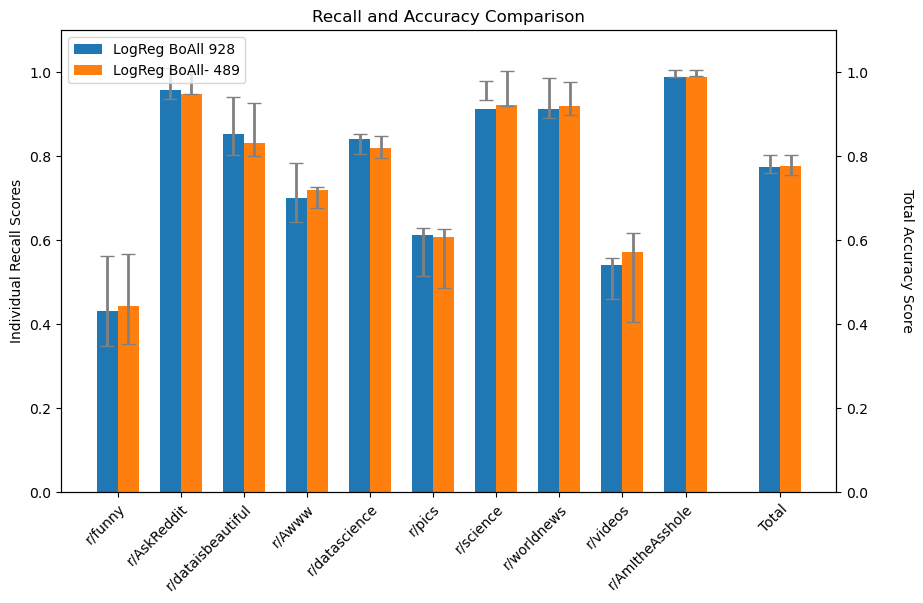

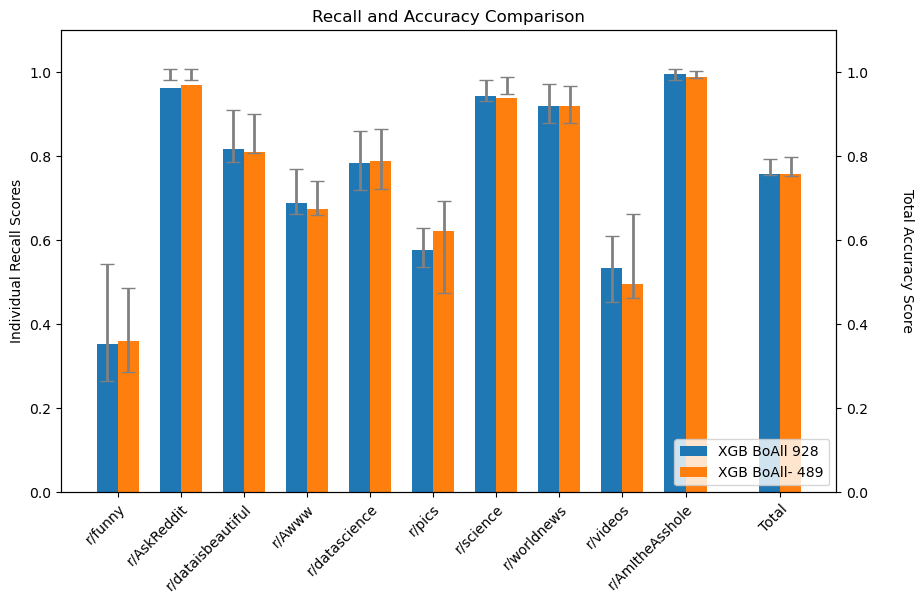

In [105]:
obj.compare(['LogReg BoAll 928', 'LogReg BoAll- 489'], error_bars=True)
obj.compare(['XGB BoAll 928', 'XGB BoAll- 489'], error_bars = True)

In [ ]:
obj.new_train_model('NN BoAll- 489', important_features, 'NN', "A neural Net trained using the top 500 BoW words and all other features, minus all features with an importance score of 0.")


In [107]:
len(obj.X_train)

7258

In [198]:

def _NN_train(X_train, Y_train):
    # Convert the input data to tensors
    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    Y_train = torch.tensor(Y_train.values, dtype=torch.long)

    # Initialize the neural network
    input_size = X_train.shape[1]
    hidden_size_1 = 256
    hidden_size_2 = 256
    hidden_size_3 = 256
    output_size = 10
    net = torch.nn.Sequential(
        torch.nn.Linear(input_size, hidden_size_1),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size_1, hidden_size_2),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size_2, hidden_size_3),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size_3, output_size)
    )

    # Define the loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

    total_epochs = 100000
    progress_bar = tqdm(total = total_epochs, desc= "Progress")
    # Train the model
    best_loss = 10
    for epoch in range(total_epochs):
        outputs = net(X_train)
        loss = criterion(outputs, Y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if loss.item()<best_loss:
            best_loss = loss.item()
            best_model = copy.deepcopy(net)

        if (epoch + 1) % 100 == 0: # Update the text every 100 iterations
            progress_bar.set_description(f'Current: {loss.item():.4f}, Best: {best_loss:.4f}')
        progress_bar.update(1)

    progress_bar.close()
    #return net
    return best_model

def _NN_predict(X_test, model):
    # Convert the input data to tensors
    X_test = torch.tensor(X_test.values, dtype=torch.float32)

    # Make predictions
    with torch.no_grad():
        outputs = model(X_test)
        _, predictions = torch.max(outputs, 1)

    return pd.Series(predictions.numpy())

NN = Classifier("NN")
NN._train = _NN_train
NN._predict = _NN_predict
obj.add_classifier(NN)




Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

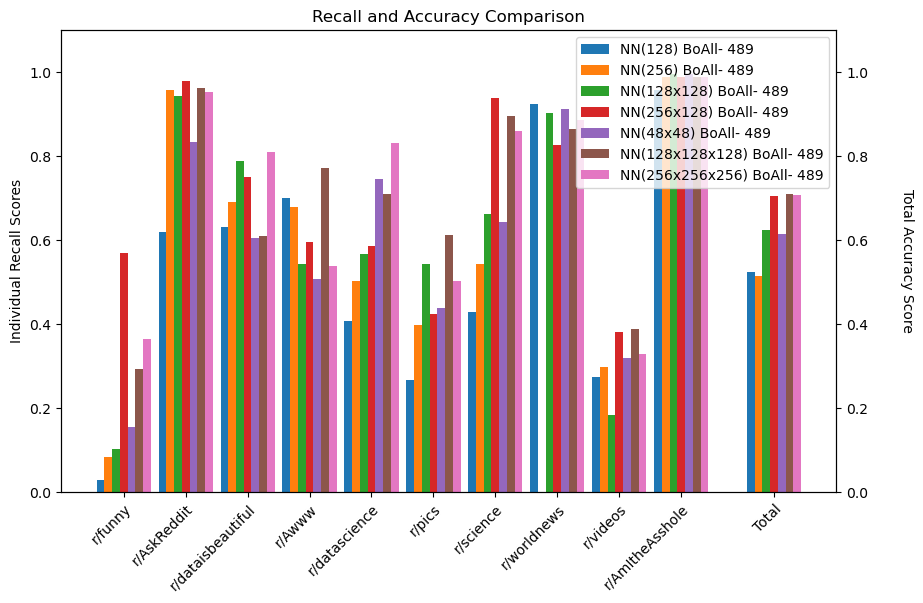

In [199]:
obj.new_train_model('NN(256x256x256) BoAll- 489', important_features, 'NN', "A Neural Net(256x256x256) trained using the top 500 BoW words and all other features, minus all features with an importance score of 0.")
obj.new_test_model('NN(256x256x256) BoAll- 489')
obj.compare(['NN(128) BoAll- 489', 'NN(256) BoAll- 489', 'NN(128x128) BoAll- 489', 'NN(256x128) BoAll- 489', 'NN(48x48) BoAll- 489', 'NN(128x128x128) BoAll- 489', 'NN(256x256x256) BoAll- 489'])

In [195]:
2+2

4

Progress:   0%|          | 0/50000 [00:00<?, ?it/s]

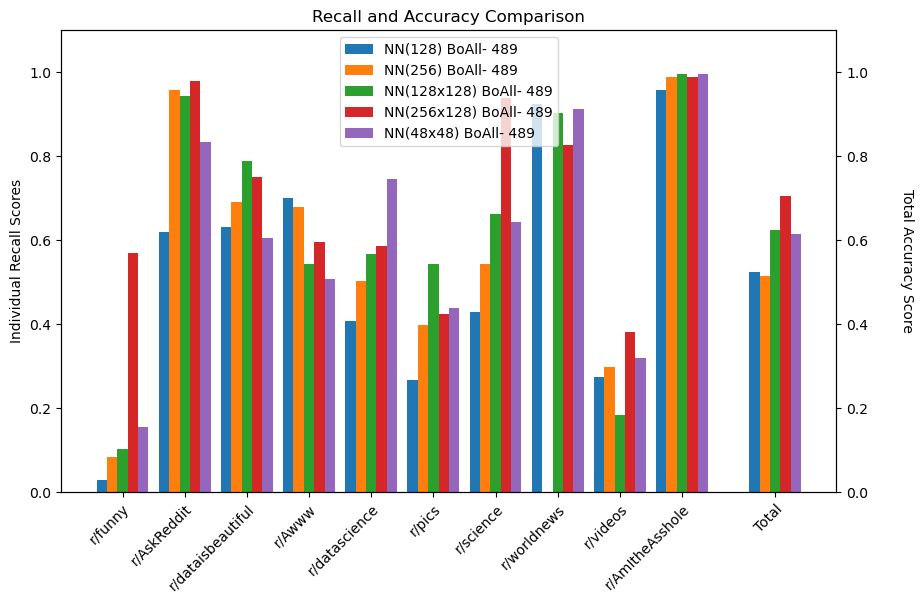

In [176]:
obj.new_train_model('NN(128x128x128) BoAll- 489', important_features, 'NN', "A neural Net trained using the top 500 BoW words and all other features, minus all features with an importance score of 0.")
obj.new_test_model('NN(256x128) BoAll- 489')
obj.compare(['NN(128) BoAll- 489', 'NN(256) BoAll- 489', 'NN(128x128) BoAll- 489', 'NN(256x128) BoAll- 489', 'NN(48x48) BoAll- 489'])

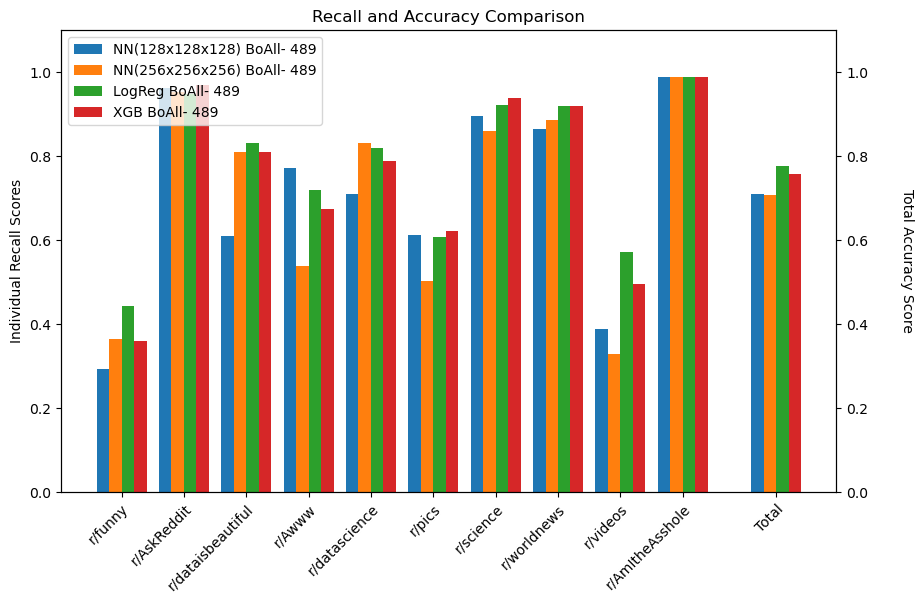

In [200]:
obj.compare(['NN(128x128x128) BoAll- 489', 'NN(256x256x256) BoAll- 489', 'LogReg BoAll- 489', 'XGB BoAll- 489' ])

In [226]:
patience = 10000 # Number of epochs with no improvement in the loss to stop

def _NN2_train(X_train, Y_train):

    # Convert the input data to tensors
    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    Y_train = torch.tensor(Y_train.values, dtype=torch.long)

    # Initialize the neural network
    input_size = X_train.shape[1]
    hidden_size_1 = 256
    hidden_size_2 = 256
    hidden_size_3 = 256
    output_size = 10
    net = torch.nn.Sequential(
        torch.nn.Linear(input_size, hidden_size_1),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size_1, hidden_size_2),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size_2, hidden_size_3),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size_3, output_size)
    )

    # Define the loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    # Add L2 regularization to the loss function
    l2_reg = torch.tensor(0.01)
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01, weight_decay=0.0001)

    total_epochs = 100000
    progress_bar = tqdm(total = total_epochs, desc= "Progress")
    # Train the model
    best_loss = 10
    best_model = copy.deepcopy(net)
    best_epoch = 0
    for epoch in range(total_epochs):
        outputs = net(X_train)
        loss = criterion(outputs, Y_train) #+ 0.5 * weight_decay * torch.norm(net.parameters(), p=2) ** 2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if loss.item()<best_loss:
            best_loss = loss.item()
            best_model = copy.deepcopy(net)
            best_epoch = epoch
        else:
            if (epoch - best_epoch) >= patience:
                print(f'Early stopping triggered at epoch {epoch + 1}')
                print('Current loss: ' + str(loss.item()))
                print('Patience: ' + str(patience))
                print('Best Epoch: ' + str(best_epoch))
                break

        if (epoch + 1) % 100 == 0: # Update the text every 100 iterations
            progress_bar.set_description(f'Current: {loss.item():.4f}, Best: {best_loss:.4f}')
        progress_bar.update(1)

    progress_bar.close()
    #return net
    return best_model

def _NN2_predict(X_test, model):
    # Convert the input data to tensors
    X_test = torch.tensor(X_test.values, dtype=torch.float32)

    # Make predictions
    with torch.no_grad():
        outputs = model(X_test)
        _, predictions = torch.max(outputs, 1)

    return pd.Series(predictions.numpy())

NN2 = Classifier("NN2")
NN2._train = _NN2_train
NN2._predict = _NN2_predict
obj.add_classifier(NN2)


Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Early stopping triggered at epoch 80101
Current loss: 0.5734844207763672
Patience: 10000
Best Epoch: 70100


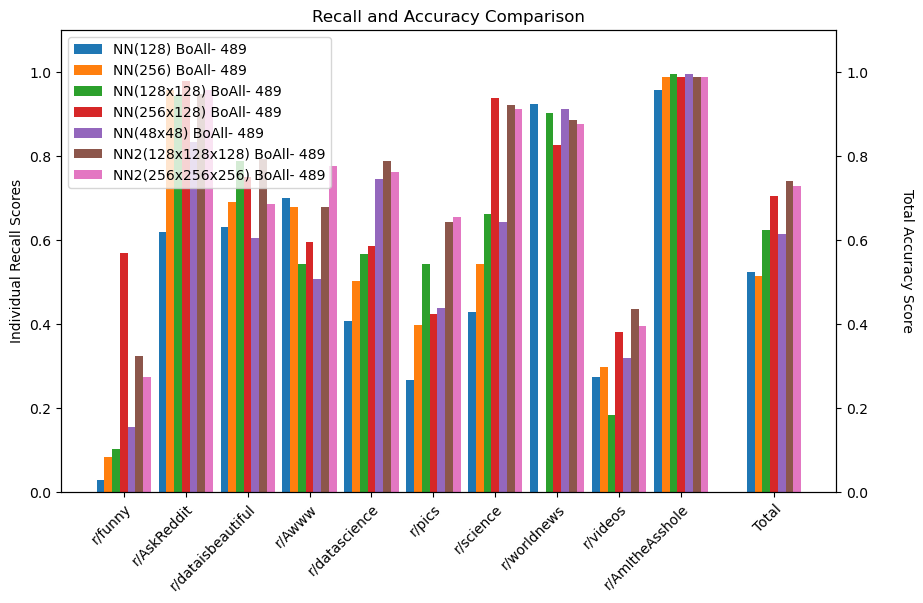

In [227]:
obj.new_train_model('NN2(256x256x256) BoAll- 489', important_features, 'NN2',
                    "A neural Net2(256x256x256) trained using the top 500 BoW words and all other features, minus all features with an importance score of 0.")
obj.new_test_model('NN2(256x256x256) BoAll- 489')
obj.compare(['NN(128) BoAll- 489', 'NN(256) BoAll- 489', 'NN(128x128) BoAll- 489', 'NN(256x128) BoAll- 489',
             'NN(48x48) BoAll- 489', 'NN2(128x128x128) BoAll- 489', 'NN2(256x256x256) BoAll- 489'])

Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

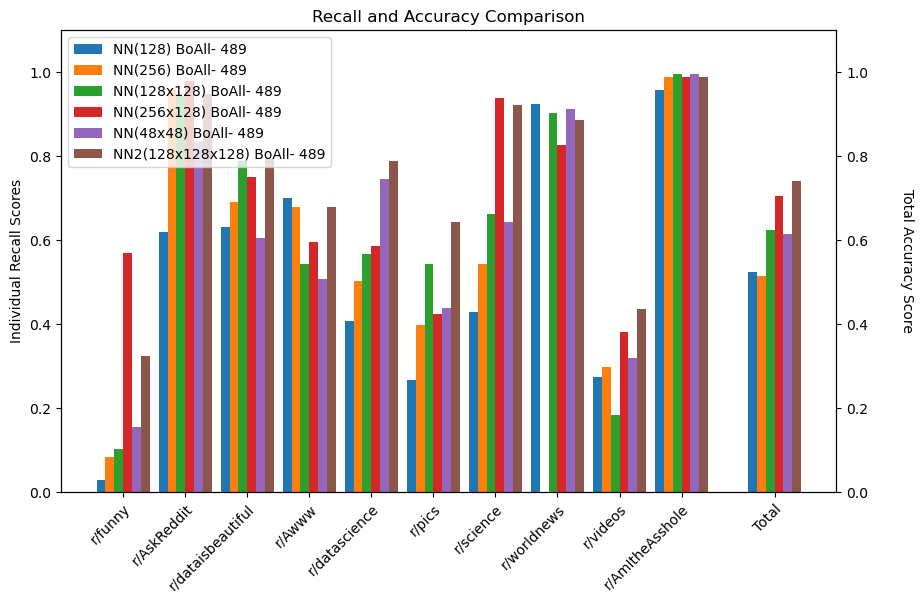

In [225]:
obj.new_train_model('NN2(256x256x256) BoAll- 489', important_features, 'NN2', "A neural Net2(256x256x256) trained using the top 500 BoW words and all other features, minus all features with an importance score of 0.")
obj.new_test_model('NN2(256x256x256) BoAll- 489')
obj.compare(['NN(128) BoAll- 489', 'NN(256) BoAll- 489', 'NN(128x128) BoAll- 489', 'NN(256x128) BoAll- 489', 'NN(48x48) BoAll- 489', 'NN2(128x128x128) BoAll- 489', 'NN2(256x256x256) BoAll- 489'])

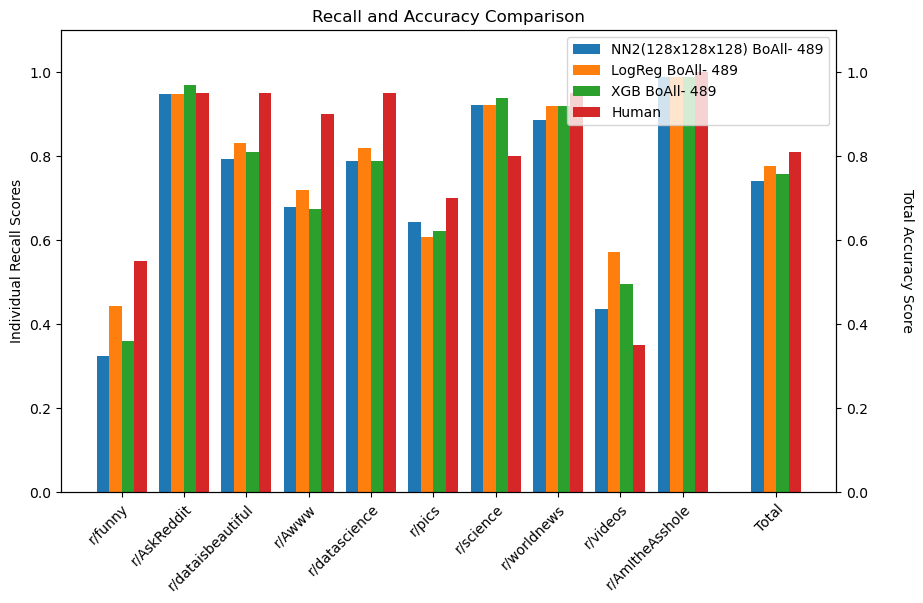

In [229]:
obj.compare(['NN2(128x128x128) BoAll- 489', 'LogReg BoAll- 489', 'XGB BoAll- 489', 'Human'])

In [148]:
from tqdm.notebook import tqdm
import time

# Initialize the progress bar
with tqdm(total=100, desc="Loop progress") as progress_bar:
#progress_bar = tqdm(total=100, desc="Loop progress")

    # Loop through a range of 100
    for i in range(100):
        time.sleep(0.1) # Add a sleep time to slow down the loop and demonstrate the text updates
        if i % 10 == 0: # Update the text every 10 iterations
            progress_bar.set_description(f"Loop progress ({i}/100)")
        progress_bar.update(1)

    # Close the progress bar when the loop is finished
    #progress_bar.close()


Loop progress:   0%|          | 0/100 [00:00<?, ?it/s]

In [149]:
pbar = tqdm(total=100)
for i in range(10):
    sleep(0.1)
    #pbar.update(10)
pbar.close()

  0%|          | 0/100 [00:00<?, ?it/s]

In [322]:
obj.new_train_model('SVM BoW', BoW_features, 'SVM', "A Support Vector Machine, trained using only the full Bag-of-Words.")
obj.new_test_model('SVM BoW')

In [323]:
obj.new_train_model('RF BoW', BoW_features, 'RF', "A Random Forrest, trained using only the full Bag-of-Words.")
obj.new_test_model('RF BoW')

In [324]:
obj.new_train_model('XGB BoW', BoW_features, 'XGB', "A XGBoost model, trained using only the full Bag-of-Words.")
obj.new_test_model('XGB BoW')

In [337]:
obj.new_validate('XGB BoW', 5)

100%|██████████| 5/5 [09:46<00:00, 117.32s/it]


In [335]:
obj.new_train_model('NN BoW', BoW_features, 'NN', "A Neural Net, trained using only the full Bag-of-Words.")
obj.new_test_model('NN BoW')

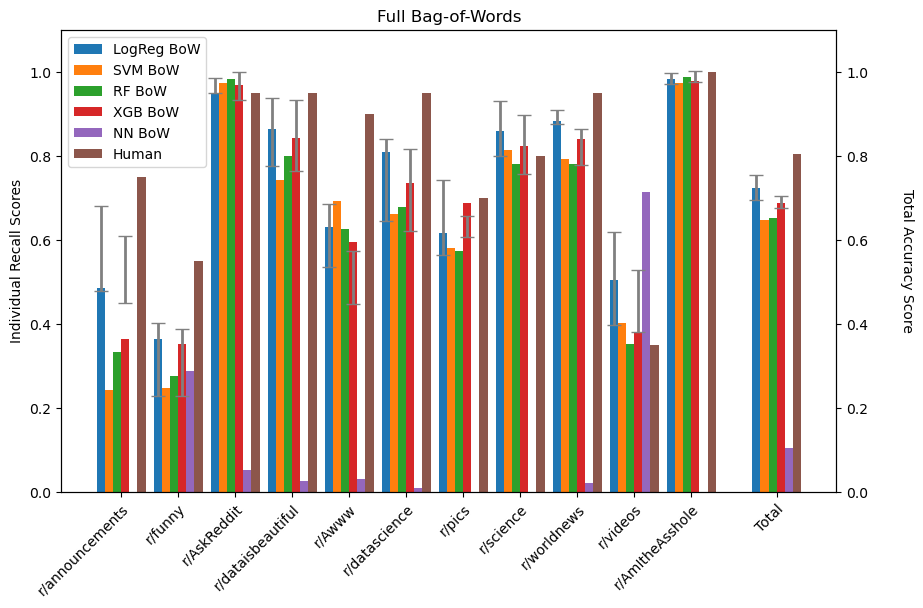

In [338]:
obj.compare(['LogReg BoW', 'SVM BoW', 'RF BoW', 'XGB BoW', 'NN BoW', 'Human'], error_bars=True, title = "Full Bag-of-Words")

Let's look at the features that were important to these models. RF and XGB have a built in importants thing, so we'll use those. Let's find the top 200 important words from each, and train the models again.

In [368]:
# extract the feature importances
importances = obj.Models['RF BoW'].model.feature_importances_

# create a pandas dataframe of the feature importances
importance_df_rf = pd.DataFrame({"feature": BoW_features, "importance": importances})

# sort the dataframe by feature importance
importance_df_rf.sort_values(by="importance", ascending=False, inplace=True)

# print the top 10 most important features
print(importance_df_rf.head(204))

               feature  importance
202          BoW: _oc_    0.036696
197             BoW: ?    0.036274
351          BoW: aita    0.029372
6204         BoW: what    0.021551
3785           BoW: my    0.017124
...                ...         ...
5388        BoW: state    0.000644
2639          BoW: had    0.000642
3033  BoW: introducing    0.000642
6200         BoW: were    0.000630
6371            BoW: “    0.000629

[204 rows x 2 columns]


In [367]:
# extract the feature importances
importances = obj.Models['XGB BoW'].model.feature_importances_


# create a pandas dataframe of the feature importances
importance_df_xgb = pd.DataFrame({"feature": BoW_features, "importance": importances})

# sort the dataframe by feature importance
importance_df_xgb.sort_values(by="importance", ascending=False, inplace=True)

# print the top 10 most important features
print(importance_df_xgb.head(204))

           feature  importance
351      BoW: aita    0.045008
5473    BoW: study    0.021540
6204     BoW: what    0.013480
5921  BoW: ukraine    0.013278
6224    BoW: wibta    0.013024
...            ...         ...
992      BoW: came    0.001165
6011  BoW: vaccine    0.001165
5136     BoW: shit    0.001164
3068   BoW: island    0.001163
3963       BoW: of    0.001160

[204 rows x 2 columns]


In [397]:
BoW_features_200 = list(set(list(importance_df_xgb.sort_values('importance', ascending=False).head(200)['feature']) + list(importance_df_xgb.sort_values('importance', ascending=False).head(200)['feature'])))
BoW_features_200.sort()
print(len(BoW_features_200))
BoW_features_200

200


['BoW: !',
 'BoW: #',
 "BoW: '",
 'BoW: -',
 'BoW: ...',
 'BoW: 2022',
 'BoW: 23f',
 'BoW: 90',
 'BoW: ?',
 'BoW: _oc_',
 'BoW: ability',
 'BoW: adorable',
 'BoW: adults',
 'BoW: advice',
 'BoW: ago',
 'BoW: ai',
 'BoW: aita',
 'BoW: aita-',
 'BoW: aitah',
 'BoW: ama',
 'BoW: analysis',
 'BoW: and',
 'BoW: anime',
 'BoW: anyone',
 'BoW: associated',
 'BoW: attack',
 'BoW: average',
 'BoW: baby',
 'BoW: bbc',
 'BoW: beach',
 'BoW: bit',
 'BoW: boi',
 'BoW: brain',
 'BoW: brazil',
 'BoW: calls',
 'BoW: came',
 'BoW: cancer',
 'BoW: carbon',
 'BoW: career',
 'BoW: cartoon',
 'BoW: cartoons',
 'BoW: cat',
 'BoW: charges',
 'BoW: chatgpt',
 'BoW: chief',
 'BoW: china',
 'BoW: christmas',
 'BoW: could',
 'BoW: countries',
 'BoW: country',
 'BoW: covid-19',
 'BoW: cute',
 'BoW: cutie',
 'BoW: data',
 'BoW: dataset',
 'BoW: dec',
 'BoW: disease',
 'BoW: dog',
 'BoW: ds',
 'BoW: during',
 'BoW: each',
 'BoW: eating',
 'BoW: edit',
 'BoW: emergency',
 'BoW: episode',
 'BoW: eu',
 'BoW: evidence'

In [370]:
obj.new_train_model('LogReg BoW 200', BoW_features_200, 'LogReg', "A Multinomial Logistic Regression, trained using only the top 200 words from Bag-of-Words.")
obj.new_test_model('LogReg BoW 200')
obj.new_validate('LogReg BoW 200', 5)

C:\Users\raino\AppData\Local\Temp\ipykernel_12384\766555005.py:126: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train = self.ALL_FEATURES.loc[self._train_index, feature_list]
C:\Users\raino\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\raino\AppData\Local\Temp\ipykernel_12384\766555005.py:142: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_test = self.ALL_FEATURES.loc[self._test_index, featur

In [371]:
obj.new_train_model('RF BoW 200', BoW_features_200, 'RF', "A Random Forrest model, trained using only the top 200 words from Bag-of-Words.")
obj.new_test_model('RF BoW 200')
obj.new_validate('RF BoW 200', 5)

C:\Users\raino\AppData\Local\Temp\ipykernel_12384\766555005.py:126: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train = self.ALL_FEATURES.loc[self._train_index, feature_list]
C:\Users\raino\AppData\Local\Temp\ipykernel_12384\766555005.py:142: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_test = self.ALL_FEATURES.loc[self._test_index, feature_list]
C:\Users\raino\AppData\Local\Temp\ipykernel_12384\766555005.py:169: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train = self.ALL_FEATURES.loc[self._train_index, feature_list]
100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


In [372]:
obj.new_train_model('XGB BoW 200', BoW_features_200, 'XGB', "An XGBoost model, trained using only the top 200 words from Bag-of-Words.")
obj.new_test_model('XGB BoW 200')
obj.new_validate('XGB BoW 200', 5)

C:\Users\raino\AppData\Local\Temp\ipykernel_12384\766555005.py:126: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train = self.ALL_FEATURES.loc[self._train_index, feature_list]
C:\Users\raino\AppData\Local\Temp\ipykernel_12384\766555005.py:142: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_test = self.ALL_FEATURES.loc[self._test_index, feature_list]
C:\Users\raino\AppData\Local\Temp\ipykernel_12384\766555005.py:169: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train = self.ALL_FEATURES.loc[self._train_index, feature_list]
100%|██████████| 5/5 [00:20<00:00,  4.13s/it]


In [373]:
obj.new_train_model('NN BoW 200', BoW_features_200, 'NN', "A Neural Net model, trained using only the top 200 words from Bag-of-Words.")
obj.new_test_model('NN BoW 200')
obj.new_validate('NN BoW 200', 5)

C:\Users\raino\AppData\Local\Temp\ipykernel_12384\766555005.py:126: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train = self.ALL_FEATURES.loc[self._train_index, feature_list]
C:\Users\raino\AppData\Local\Temp\ipykernel_12384\766555005.py:142: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_test = self.ALL_FEATURES.loc[self._test_index, feature_list]
C:\Users\raino\AppData\Local\Temp\ipykernel_12384\766555005.py:169: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train = self.ALL_FEATURES.loc[self._train_index, feature_list]
100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


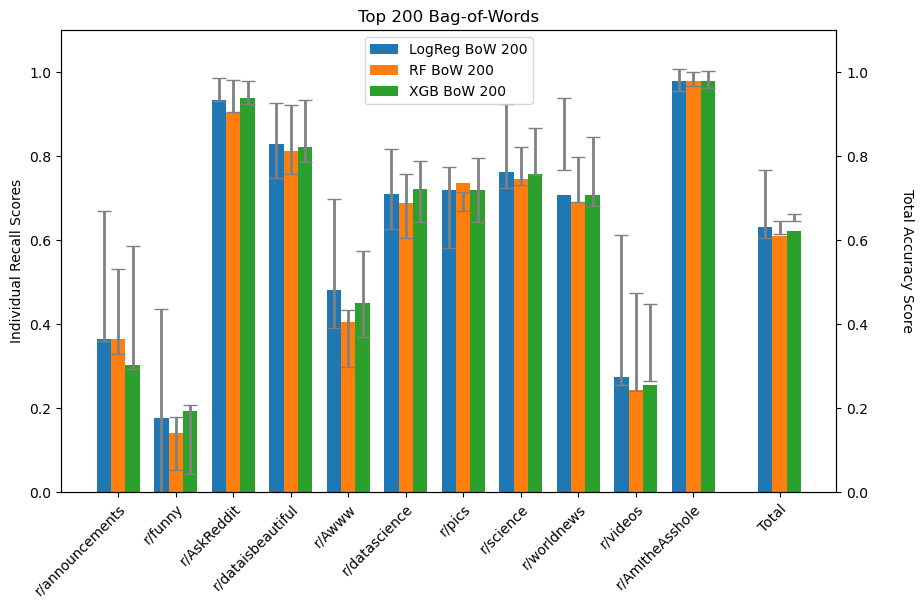

In [375]:
obj.compare(['LogReg BoW 200', 'RF BoW 200', 'XGB BoW 200'], error_bars=True, title = "Top 200 Bag-of-Words")


In [383]:
obj.new_validate('XGB BoW 200', 10)

C:\Users\raino\AppData\Local\Temp\ipykernel_12384\766555005.py:169: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train = self.ALL_FEATURES.loc[self._train_index, feature_list]
100%|██████████| 10/10 [00:41<00:00,  4.12s/it]


In [384]:
obj.Cross_Validation_Results

announcements     funny AskReddit dataisbeautiful  \
Model          Test No.                                                     
Aux            1                  0.0  0.186275  0.422414        0.252252   
               2                  0.0  0.166667  0.456897        0.378378   
               3                  0.0  0.137255  0.465517        0.333333   
               4                  0.0  0.186275  0.439655        0.405405   
               5                  0.0  0.117647  0.474138        0.261261   
LogReg BoW     1                  0.6  0.284314  0.982759         0.81982   
               2                  0.5  0.264706  0.965517        0.918919   
               3                 0.55  0.323529  0.965517        0.810811   
               4                 0.65  0.313725  0.974138        0.882883   
               5                  0.6  0.392157  0.956897        0.855856   
XGB BoW        1                  0.6  0.294118  0.991379         0.81982   
               2                  0.5   0.27451  0.965517        0.882883   
               3                  0.5  0.372549  0.974138        0.783784   
               4                  0.5  0.264706  0.965517        0.900901   
               5                 0.55  0.333333  0.939655        0.855856   
LogReg BoW 200 1                  0.6  0.284314  0.982759         0.81982   
               2                  0.5  0.264706  0.965517        0.918919   
               3                 0.55  0.323529  0.965517        0.810811   
               4                 0.65  0.313725  0.974138        0.882883   
               5                  0.6  0.392157  0.956897        0.855856   
               6                 0.45  0.107843  0.956897         0.81982   
               7                 0.45  0.117647  0.939655        0.747748   
               8                  0.5  0.107843  0.956897        0.864865   
               9                  0.4  0.039216  0.939655        0.846847   
               10                0.45  0.117647  0.948276        0.810811   
RF BoW 200     1                  0.4  0.117647  0.931034        0.801802   
               2                 0.35  0.088235  0.931034        0.882883   
               3                  0.5  0.166667  0.974138        0.783784   
               4                 0.45  0.078431  0.956897        0.882883   
               5                 0.45  0.127451  0.922414        0.846847   
XGB BoW 200    1                  0.5  0.088235  0.956897         0.81982   
               2                 0.35  0.107843  0.948276        0.900901   
               3                  0.5  0.205882  0.974138        0.810811   
               4                  0.5  0.107843  0.948276        0.891892   
               5                 0.35  0.117647  0.931034        0.873874   
NN BoW 200     1                  0.0  0.009804  0.008621             0.0   
               2                  0.0       0.0  0.577586        0.036036   
               3                  0.0       0.0  0.474138             0.0   
               4                  0.0       0.0  0.405172        0.117117   
               5                  0.0       0.0  0.991379        0.693694   
XGB BoW 200    6                 0.45  0.117647  0.948276        0.828829   
               7                 0.45  0.127451  0.931034        0.774775   
               8                  0.5  0.088235  0.948276        0.873874   
               9                  0.4  0.127451  0.939655        0.828829   
               10                0.45  0.078431  0.939655        0.783784   
               11                0.35  0.098039  0.896552        0.846847   
               12                0.55  0.098039  0.939655        0.828829   
               13                0.45  0.127451  0.965517        0.837838   
               14                 0.4  0.039216  0.991379        0.900901   
               15                0.45  0.205882  0.965517        0.792793   
               16   

In [391]:
#temp_df = obj.full_data.loc[obj._train_index]
temp_df = obj.full_data.copy()

temp_df.loc[temp_df['subreddit'] == 'announcements' ]

,title,subreddit,subreddit_num
id,,,
t93ec3,This subreddit is closed for new posts and com...,announcements,3
pg006s,COVID denialism and policy clarifications,announcements,3
pbmy5y,"Debate, dissent, and protest on Reddit",announcements,3
nw2hs6,Sunsetting Secret Santa and Reddit Gifts,announcements,3
mi01fg,Second,announcements,3
...,...,...,...
aep20,"About the little red ""NSFW"" that appears next ...",announcements,3
adbka,Sorry for the slowness in voting and commentin...,announcements,3
acvfx,blog.reddit -- self serve advertising on reddi...,announcements,3


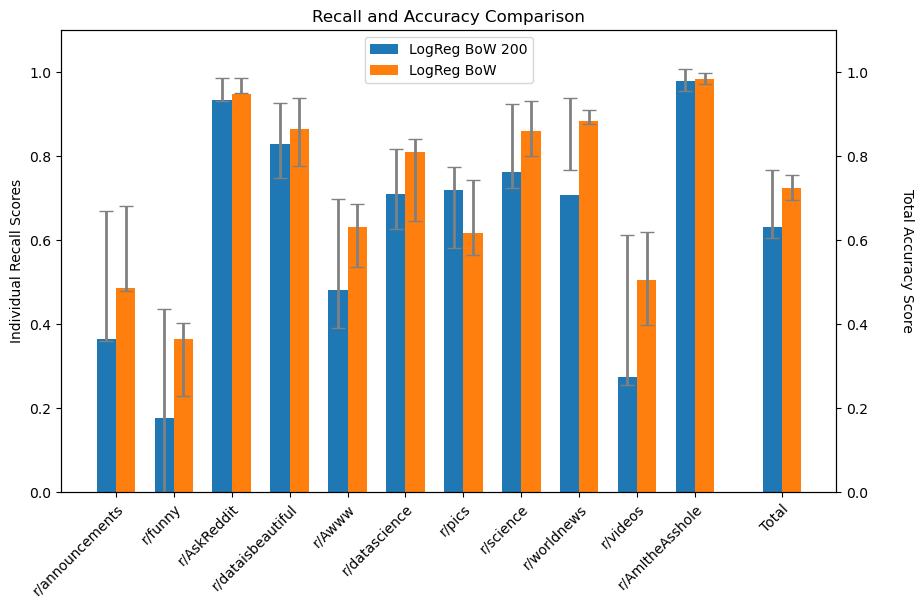

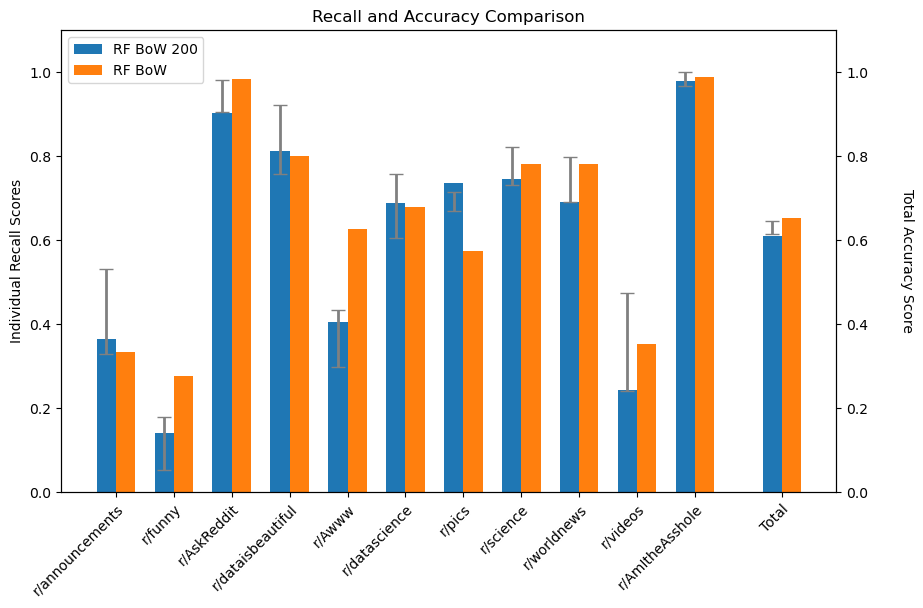

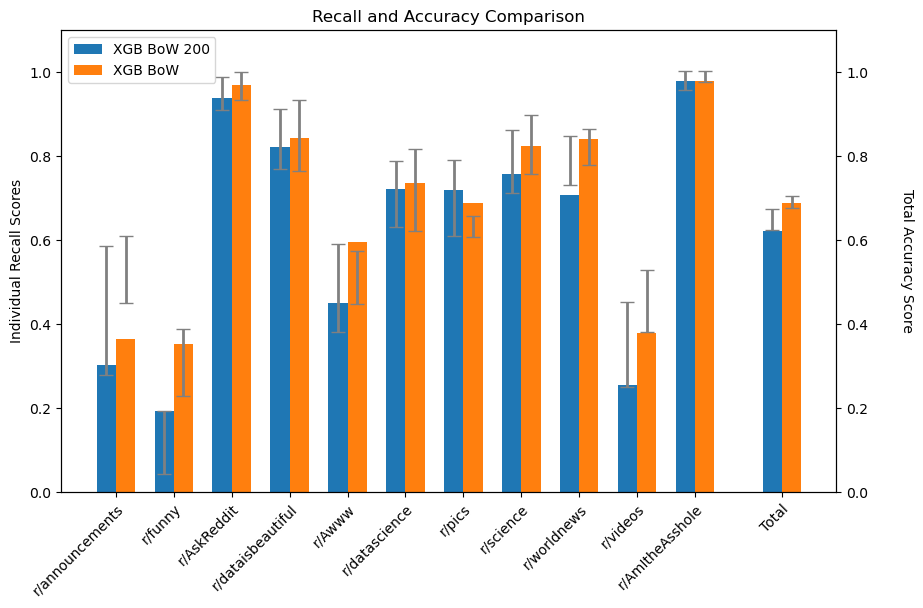

In [398]:
obj.compare(['LogReg BoW 200', 'LogReg BoW'], error_bars=True)
obj.compare(['RF BoW 200', 'RF BoW'], error_bars=True)
obj.compare(['XGB BoW 200', 'XGB BoW'], error_bars=True)


Let's try the same thing with 500 words

## Feature Selection

In [119]:
aux_features = [col for col in obj.ALL_FEATURES.columns if 'Aux:' in col]
BoC_features = [col for col in obj.ALL_FEATURES.columns if 'BoC:' in col]
PoS_features = [col for col in obj.ALL_FEATURES.columns if 'PoS:' in col]
BoW_features = [col for col in obj.ALL_FEATURES.columns if 'BoW:' in col]




In [120]:
obj.new_train_model('Aux', aux_features, 'RF' , description="A Random Forest model using only Auxiliary features.")
obj.new_train_model('BoC', BoC_features, 'RF' , description="A Random Forest model using only Bag-of-Character features.")
obj.new_train_model('BoC+Aux', aux_features + BoC_features , 'RF' , description="A Random Forest model using Bag-of-Character + auxiliary features.")

In [121]:
obj.Predictions

,title,actual
id,,
10m7d9b,Egypt plans to allot land to Indian industries...,worldnews
105bmlo,the princess resting ❤️,Awww
zz0muf,Contour Map of the Sub Continent [OC],dataisbeautiful
10q4jw2,James Gunn DC Slate Announcement,videos
10kzv8m,Zambian student who died fighting for Russia i...,worldnews
...,...,...
10b8czt,Sociodemographic factors such as mortality rat...,science
10l60a3,Study shows how cells prevent harmful extra DN...,science
10lrffj,My adorable pet rats Banana (gray) and Donut (...,Awww


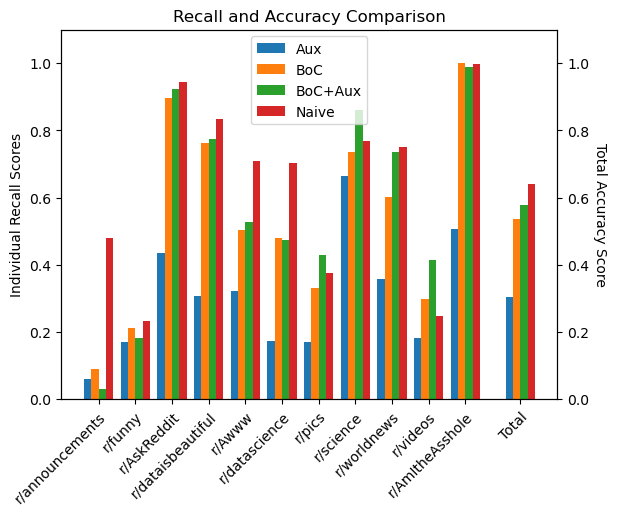

In [122]:
obj.new_test_model('Aux')
obj.new_test_model('BoC')
obj.new_test_model('BoC+Aux')


obj.compare(['Aux', 'BoC', 'BoC+Aux', 'Naive'])


In [123]:
obj.new_train_model('XGB_aux_compare', aux_features , 'XGB',  description="An XGBoost model using only auxiliary features.")
obj.new_test_model('XGB_aux_compare')

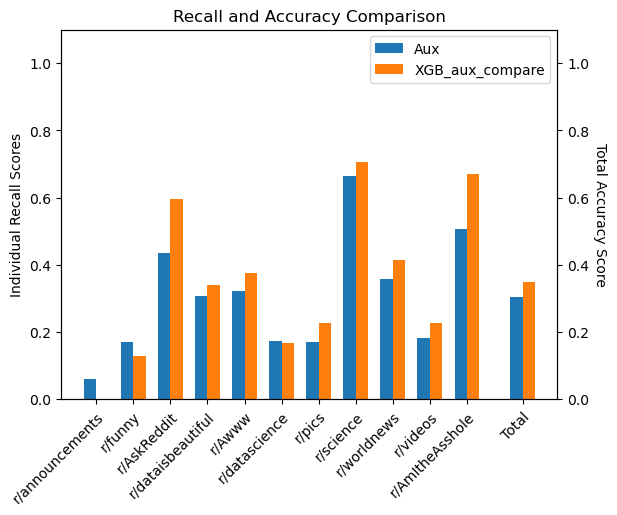

In [124]:
obj.compare(['Aux', 'XGB_aux_compare'])

In [125]:
obj.new_train_model('LogReg_aux_compare', aux_features , 'LogReg',  description="A multinomial logistic regression model using only auxiliary features.")
obj.new_test_model('LogReg_aux_compare')

C:\Users\raino\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


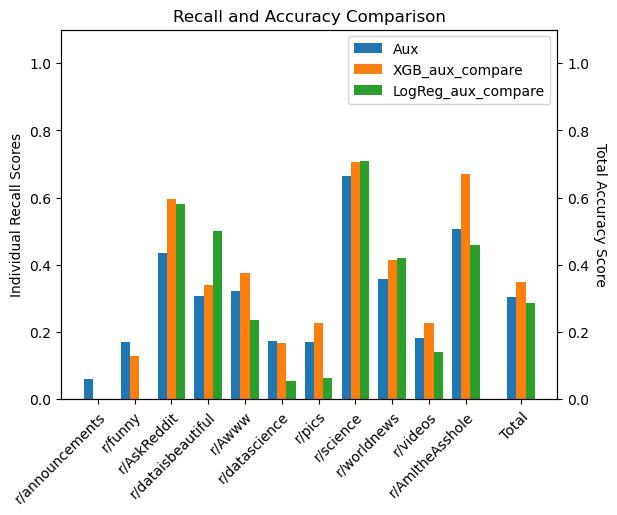

In [126]:
obj.compare(['Aux', 'XGB_aux_compare','LogReg_aux_compare' ])

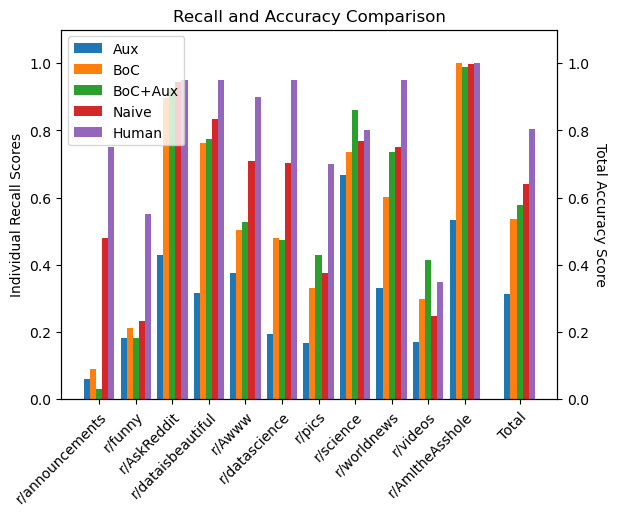

In [127]:
obj = UPDATE_obj(obj, path)

obj.new_train_model('Aux', aux_features, 'RF' , description="A Random Forest model using only Auxiliary features.")
obj.new_test_model('Aux')


obj.compare(['Aux', 'BoC', 'BoC+Aux', 'Naive', 'Human'])

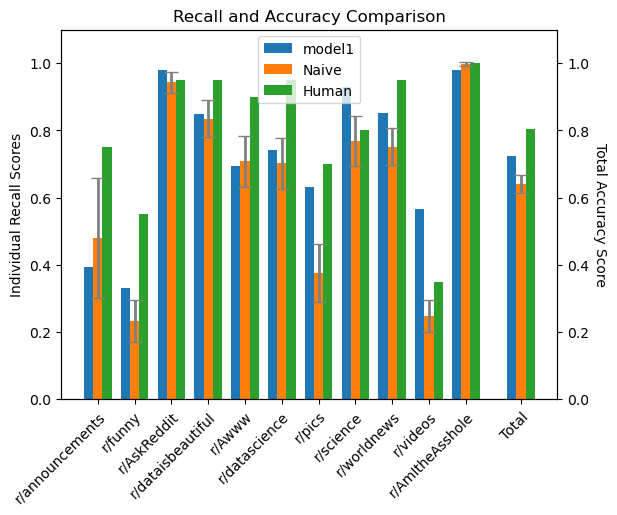

In [128]:
obj.new_train_model('model1', aux_features + BoW_features, 'XGB' , description="An XGB model using all BoW features + Aux features.")
obj.new_test_model('model1')
obj.compare(['model1', 'Naive', 'Human'], error_bars=True)

In [307]:
obj.new_train_model('model3', aux_features + BoW_features, 'NN' , description="An NN model using all BoW features + Aux features.")
obj.new_test_model('model3')
obj.compare(['model1', 'model2', 'model3', 'Human'], error_bars=True)

AttributeError: 'numpy.float64' object has no attribute 'backward'

In [302]:
obj.Predictions

,title,actual,Aux,BoC,BoC+Aux,XGB_aux_compare,LogReg_aux_compare,model1,NN,NN_aux,model2
id,,,,,,,,,,,
10m7d9b,Egypt plans to allot land to Indian industries...,worldnews,worldnews,pics,worldnews,worldnews,science,worldnews,science,science,science
105bmlo,the princess resting ❤️,Awww,Awww,Awww,Awww,Awww,Awww,Awww,AskReddit,science,science
zz0muf,Contour Map of the Sub Continent [OC],dataisbeautiful,AmItheAsshole,dataisbeautiful,dataisbeautiful,videos,videos,dataisbeautiful,dataisbeautiful,dataisbeautiful,dataisbeautiful
10q4jw2,James Gunn DC Slate Announcement,videos,videos,datascience,datascience,videos,worldnews,videos,dataisbeautiful,AmItheAsshole,dataisbeautiful
10kzv8m,Zambian student who died fighting for Russia i...,worldnews,worldnews,worldnews,worldnews,worldnews,worldnews,worldnews,science,science,science
...,...,...,...,...,...,...,...,...,...,...,...
10b8czt,Sociodemographic factors such as mortality rat...,science,science,pics,science,science,science,science,science,science,science
10l60a3,Study shows how cells prevent harmful extra DN...,science,worldnews,science,science,science,science,science,science,science,science
10lrffj,My adorable pet rats Banana (gray) and Donut (...,Awww,worldnews,Awww,Awww,datascience,dataisbeautiful,Awww,worldnews,science,science


In [162]:
obj.Cross_Validation_Results_std.loc['temp'] = {}
obj.Cross_Validation_Results_std

C:\Users\raino\AppData\Local\Temp\ipykernel_12384\4101083042.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  obj.Cross_Validation_Results_std.loc['temp'] = {}


,announcements,funny,AskReddit,dataisbeautiful,Awww,datascience,pics,science,worldnews,videos,AmItheAsshole,Total
Model,,,,,,,,,,,,
Naive,0.089083,0.031715,0.015738,0.027367,0.03744,0.037809,0.042773,0.037464,0.027039,0.024318,0.003079,0.012883
temp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [232]:
obj = UPDATE_obj(obj,path)
obj.Cross_Validation_Results.drop('Aux', inplace=True)
#obj.Cross_Validation_Results.drop(columns=[1], inplace=True)
obj.new_validate('Aux',4)
obj.Cross_Validation_Results

100%|██████████| 4/4 [00:01<00:00,  2.05it/s]


announcements     funny AskReddit dataisbeautiful      Awww  \
Model Test No.                                                               
Aux   1                  0.0  0.235294  0.431034        0.243243  0.324786   
      2                  0.0  0.166667  0.482759         0.36036  0.316239   
      3                  0.0  0.137255  0.431034        0.342342  0.307692   
      4                  0.0  0.166667  0.439655        0.342342  0.333333   
      5                  0.0  0.078431  0.465517        0.243243  0.376068   
      6                  0.0  0.166667  0.439655         0.27027  0.307692   
      7                  0.0  0.186275  0.422414         0.27027  0.264957   
      8                  0.0  0.147059  0.431034        0.297297  0.307692   
      9                  0.0  0.196078  0.474138        0.252252   0.25641   

               datascience      pics   science worldnews    videos  \
Model Test No.                                                       
Aux   1           0.201754  0.198276  0.732759  0.348214  0.222222   
      2           0.140351  0.206897  0.715517  0.330357   0.10101   
      3           0.263158  0.137931   0.62069  0.339286   0.20202   
      4           0.157895  0.258621   0.62069  0.410714  0.242424   
      5           0.131579  0.206897  0.663793  0.401786  0.191919   
      6           0.149123  0.215517  0.663793  0.357143  0.181818   
      7           0.149123  0.258621  0.698276  0.401786  0.262626   
      8           0.157895  0.172414  0.672414  0.410714  0.212121   
      9           0.166667      0.25  0.681034  0.392857   0.20202   

               AmItheAsshole     Total  
Model Test No.                          
Aux   1             0.610619  0.322564  
      2             0.619469  0.312693  
      3             0.575221  0.305148  
      4             0.477876  0.313656  
      5             0.610619   0.30635  
      6             0.610619  0.305663  
      7             0.575221  0.317233  
      8             0.557522  0.306015  
      9             0.584071  0.314139

In [240]:
obj.Cross_Validation_Results

,,announcements,funny,AskReddit,dataisbeautiful,Awww,datascience,pics,science,worldnews,videos,AmItheAsshole,Total
Model,Test No.,,,,,,,,,,,,


In [253]:
#obj.Cross_Validation_Results.drop('Aux', inplace=True)
obj = UPDATE_obj(obj,path)
#obj.Cross_Validation_Results

obj.new_validate('Aux', 5)

100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


In [256]:
obj.Cross_Validation_Results_avg

,announcements,funny,AskReddit,dataisbeautiful,Awww,datascience,pics,science,worldnews,videos,AmItheAsshole,Total
Model,,,,,,,,,,,,
Naive,0.478464,0.232583,0.942449,0.834654,0.707343,0.701894,0.374770,0.769103,0.751423,0.247428,0.997083,0.639745
Aux,0.000000,0.158824,0.451724,0.326126,0.331624,0.178947,0.205172,0.670690,0.358929,0.189899,0.562832,0.312252


In [266]:
import multiprocessing
import time
a = 0

def worker(num):
    print(f'Worker {num} started')
    print('hi')
    time.sleep(10)
    print(f'Worker {num} finished')
    a +=1

processes = []
for i in range(4):

    process = multiprocessing.Process(target=worker, args=(i,))
    process.start()
    processes.append(process)

for process in processes:
    process.join()

print('All processes finished')
print(a)


All processes finished
0


In [267]:
import concurrent.futures
import time

def some_function():
    print("Starting function")
    time.sleep(2)
    print("Finished function")

with concurrent.futures.ProcessPoolExecutor() as executor:
    results = [executor.submit(some_function) for i in range(4)]

    for f in concurrent.futures.as_completed(results):
        f.result()

print("All processes finished")
import concurrent.futures
import time

def some_function():
    print("Starting function")
    time.sleep(2)
    print("Finished function")

with concurrent.futures.ProcessPoolExecutor() as executor:
    results = [executor.submit(some_function) for i in range(4)]

    for f in concurrent.futures.as_completed(results):
        f.result()

print("All processes finished")


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [268]:
import concurrent.futures
import time

def worker(id):
    print(f'Worker {id} started')
    time.sleep(2)
    print(f'Worker {id} finished')

with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
    futures = [executor.submit(worker, i) for i in range(4)]
    for future in concurrent.futures.as_completed(futures):
        try:
            future.result()
        except Exception as e:
            print(f'Worker generated an exception: {e}')

print('All processes finished')


Worker generated an exception: A process in the process pool was terminated abruptly while the future was running or pending.
Worker generated an exception: A process in the process pool was terminated abruptly while the future was running or pending.
Worker generated an exception: A process in the process pool was terminated abruptly while the future was running or pending.
Worker generated an exception: A process in the process pool was terminated abruptly while the future was running or pending.
All processes finished


In [270]:
time.sleep(2)
print('hi')

hi


In [223]:
temp_df = obj.Cross_Validation_Results.copy()
temp_df.loc[('hi',1), :] = {}
temp_df

C:\Users\raino\AppData\Local\Temp\ipykernel_12384\1433934871.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  temp_df.loc[('hi',1), :] = {}


,,announcements,funny,AskReddit,dataisbeautiful,Awww,datascience,pics,science,worldnews,videos,AmItheAsshole,Total
Model,Test No.,,,,,,,,,,,,
Aux,1,0.0,0.215686,0.422414,0.252252,0.324786,0.219298,0.232759,0.741379,0.330357,0.171717,0.584071,0.317702
hi,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [214]:
temp_df['Test No.']

KeyError: 'Test No.'

In [197]:
#obj.Cross_Validation_Results = obj.Cross_Validation_Results.drop('Atux')
temp_df = obj.Cross_Validation_Results.copy().drop('Aux', 'Aux3')
row = {'announcements': 0.0, 'funny': 0.22549019607843138, 'AskReddit': 0.41379310344827586, 'dataisbeautiful': 0.2702702702702703, 'Awww': 0.3247863247863248, 'datascience': 0.21052631578947367, 'pics': 0.21551724137931033, 'science': 0.7327586206896551, 'worldnews': 0.3482142857142857, 'videos': 0.18181818181818182, 'AmItheAsshole': 0.5929203539823009, 'Total': 0.3196449903596827}
#temp_df.loc[('Aux', 1)] = row
#temp_df

In [201]:
temp_df = obj.Cross_Validation_Results.copy().drop('Aux')
print(temp_df)

Empty DataFrame
Columns: [announcements, funny, AskReddit, dataisbeautiful, Awww, datascience, pics, science, worldnews, videos, AmItheAsshole, Total, 1]
Index: []


In [130]:
obj.new_test_model('Aux')
obj.new_test_model('BoC')
obj.new_test_model('BoC+Aux')

In [131]:
obj.ALL_FEATURES

,title,subreddit,subreddit_num,Aux: num_chars,Aux: num_caps,Aux: num_lower,Aux: num_emojis,BoC: W,BoC: b,BoC: ?,...,PoS: ``,PoS: RB,PoS: NNPS,PoS: '',PoS: POS,PoS: IN,PoS: WDT,PoS: FW,PoS: VB,PoS: UH
id,,,,,,,,,,,,,,,,,,,,,
t93ec3,this subreddit is closed for new posts and com...,announcements,3,160,4,125,0,0,1,0,...,0,0,0,0,0,2,0,0,2,0
pg006s,covid denialism and policy clarifications,announcements,3,41,5,32,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pbmy5y,"debate, dissent, and protest on reddit",announcements,3,38,2,29,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
nw2hs6,sunsetting secret santa and reddit gifts,announcements,3,40,5,30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mi01fg,second,announcements,3,6,1,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10mvmxu,wibta if i planned and threw a st. patty’s par...,AmItheAsshole,0,115,8,84,0,1,0,1,...,0,2,0,0,0,2,0,0,1,0
10mvlnr,aita for lashing out at my parents?,AmItheAsshole,0,35,4,24,0,0,0,1,...,0,0,0,0,0,2,0,0,0,0
10mvlgl,aita for not wanting to spend time with my wif...,AmItheAsshole,0,65,4,48,0,0,1,1,...,0,1,0,0,1,2,0,0,1,0


In [132]:


pos_tag(nltk.word_tokenize("Hello, world!")).count(('Hello', ))

0

In [133]:
tokenized_corpus = [nltk.word_tokenize(training.loc[id]['title']) for id in training.index]
tokenized_corpus

[['what',
  'do',
  'you',
  'find',
  'to',
  'be',
  'the',
  'most',
  'disrespectful',
  'subreddit',
  'here',
  '?'],
 ['not', 'gon', 'na', 'eat', 'there'],
 ['very',
  'content',
  'cat',
  '.',
  'loving',
  'the',
  'sun',
  'and',
  'ofcourse',
  'the',
  'heated',
  'cob',
  'bench',
  'does',
  "n't",
  'hurt',
  'either',
  '.'],
 ['9', 'year', 'old', 'drifting', 'a', 'car'],
 ['watchmen', '10'],
 ['lounging', 'out'],
 ['aita',
  'for',
  'telling',
  'my',
  'mother',
  'that',
  'my',
  'sister',
  'has',
  'no',
  'manners'],
 ['daniel',
  'díaz',
  '&',
  'miguel',
  'yanover',
  '-',
  'a',
  'stab',
  'in',
  'the',
  'dark',
  '[',
  'instrumental',
  'dark',
  'jazz',
  ']',
  'electric',
  'bass',
  'guitar',
  ',',
  'electric',
  'piano',
  ',',
  'acoustic',
  'drums',
  ',',
  'tenor',
  'saxophone',
  '.'],
 ['what',
  '’',
  's',
  'the',
  'proper',
  'way',
  'to',
  'respectfully',
  'sign',
  'of',
  'to',
  'comment',
  'after',
  'a',
  'discussion',
 

In [134]:
training.loc['10q4vr2']['title']

'what do you find to be the most disrespectful subreddit here?'

In [135]:
training = clean_data(training)
get_vocab(training)

['!',
 '#',
 '$',
 '%',
 '&',
 "'",
 "''",
 "'d",
 "'data",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'the",
 "'ve",
 "'war",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '--',
 '.',
 '..',
 '...',
 '....',
 '.....',
 '/',
 '//',
 '/r/worldnews',
 '0',
 '0.4',
 '000',
 '1',
 '1,000',
 '1-10',
 '1.2',
 '1.5',
 '10',
 '10,000',
 '10-11',
 '100',
 '1000',
 '100k',
 '100m',
 '101',
 '10k',
 '10pm',
 '11',
 '112',
 '12',
 '12-4',
 '13',
 '13th',
 '14',
 '15',
 '150',
 '15th',
 '16',
 '160',
 '18',
 '1880',
 '19',
 '1910',
 '1940',
 '1945',
 '1950s',
 '1960',
 '1970',
 '1970s',
 '1980',
 '1980s',
 '1981-2022',
 '1985',
 '1987',
 '1990',
 '1990s',
 '1991',
 '1993',
 '1995',
 '1996',
 '1998',
 '1am',
 '1k',
 '1st',
 '2',
 '2,000',
 '2.4',
 '20',
 '20,000',
 '200',
 '2000',
 '2001',
 '2003',
 '2007',
 '2008',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2018-2022',
 '2019',
 '2019-2022',
 '2020',
 '2021',
 '2021-2022',
 '2021.',
 '2022',
 '2022.',
 '2023',
 '2024',
 '2026',


In [136]:
df

,title,subreddit,subreddit_num,Aux: num_chars,Aux: num_caps,Aux: num_lower,Aux: num_emojis,BoC: W,BoC: b,BoC: ?,...,PoS: ``,PoS: RB,PoS: NNPS,PoS: '',PoS: POS,PoS: IN,PoS: WDT,PoS: FW,PoS: VB,PoS: UH
id,,,,,,,,,,,,,,,,,,,,,
t93ec3,this subreddit is closed for new posts and com...,announcements,3,160,4,125,0,0,1,0,...,0,0,0,0,0,2,0,0,2,0
pg006s,covid denialism and policy clarifications,announcements,3,41,5,32,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pbmy5y,"debate, dissent, and protest on reddit",announcements,3,38,2,29,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
nw2hs6,sunsetting secret santa and reddit gifts,announcements,3,40,5,30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mi01fg,second,announcements,3,6,1,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10mvmxu,wibta if i planned and threw a st. patty’s par...,AmItheAsshole,0,115,8,84,0,1,0,1,...,0,2,0,0,0,2,0,0,1,0
10mvlnr,aita for lashing out at my parents?,AmItheAsshole,0,35,4,24,0,0,0,1,...,0,0,0,0,0,2,0,0,0,0
10mvlgl,aita for not wanting to spend time with my wif...,AmItheAsshole,0,65,4,48,0,0,1,1,...,0,1,0,0,1,2,0,0,1,0


### Naive Model+

The first thing we need to do is recreate our Naive Model. The embedding process uses Bag-of-Words. To make our lives easier in the future, we will create a generalized BoW embedding that can be easily modified.


*Cleaning* - Make everythign lower case and fix some common terms like "[oc]" to make it easier for the tokenizer
*Embedding* - "Training" a BoW model is really just creating a vacob list. We use NLTK's tokenizer
*Classifying* - As in our first approach we will use Random Forrest.

In [137]:
def clean_data(df):
    """
    :param df: Pandas DataFrame with a column 'title', or a Series
    :return: original df with the contents of the 'title' column altered. All lowercase. Replace "[oc]", "(oc)", and "[nsfw]" with "_oc_" and "_nsfw_" respectively.
    """

    if type(df) == pd.Series:
        df = pd.DataFrame(df)
        series = True
    else:
        series = False

    df['title'] = df['title'].apply(lambda s: s.lower())

    df['title'] = df['title'].apply(lambda s: s.replace("[oc]", "_oc_"))
    df['title'] = df['title'].apply(lambda s: s.replace("(oc)", "_oc_"))
    df['title'] = df['title'].apply(lambda s: s.replace("[nsfw]", "_nsfw_"))
    df['title'] = df['title'].apply(lambda s: s.replace("(nsfw)", "_nsfw_"))
    df['title'] = df['title'].apply(lambda s: s.replace("[wip]", "_wip_"))
    df['title'] = df['title'].apply(lambda s: s.replace("(wip)", "_wip_"))
    df['title'] = df['title'].apply(lambda s: s.replace("[serious]", "_serious_"))

    if series: df = df['title']

    return df

In [138]:
import nltk

def get_vocab(corpus, tokenizer=nltk.word_tokenize, num_words=False, min_frequency=2):
    """
    :param corpus: a Pandas Series, or other iterable of cleaned text sentences.
    :param tokenizer: a function that takes in a sentence and outputs a list of tokens in that sentence.
    :param num_words: If an integer is given, then this is the max number of words in the vocab.
    :param min_frequency: If an integer is given, then this is the minimum number of times a word must appear in the corpus to be included in the vocab
    :return: A list of all of the tokens in our vocab.
    """
    tokenized_corpus = [tokenizer(sentence) for sentence in corpus]
    flat_list = [word for sublist in tokenized_corpus for word in sublist]
    freq_dist = FreqDist(flat_list)
    vocab = [word for word, freq in freq_dist.items() if freq >= min_frequency]
    if num_words:
        vocab = sorted(vocab, key=lambda x: freq_dist[x], reverse=True)
        vocab = vocab[:min(num_words, len(vocab))]
    vocab.sort()
    return vocab


In [139]:

from tqdm import tqdm


def _BoW_embed(titles, vocab, tokenizer=nltk.word_tokenize):
    """
    :param titles: A Pandas Series of titles to embed
    :param vocab: A List of all the words in the vocab
    :return:
    """
    df = pd.DataFrame(titles)
    df['title_tokens'] = df['title'].apply(tokenizer)
    new_cols = {'BoW: ' + word: df['title_tokens'].apply(lambda x: Counter(x)[word]) for word in tqdm(vocab)}
    #new_cols['Not in BoW'] = df['title_tokens'].apply(lambda lis: count_not_in_list2(lis, vocab))
    new_df = pd.concat([df, pd.DataFrame(new_cols)], axis=1)
    new_df = new_df.drop(columns=['title', 'title_tokens'])

    return new_df


In [140]:
from nltk.probability import FreqDist
from collections import Counter


#Naive_BoW = Vectorizer('Naive BoW')

In [141]:
obj.Models_info

{'Aux': {'feature_list': ['Aux: num_chars',
   'Aux: num_caps',
   'Aux: num_lower',
   'Aux: num_emojis'],
  'classifierName': 'RF',
  'description': 'A Random Forest model using only Auxiliary features.'},
 'BoC': {'feature_list': ['BoC: W',
   'BoC: b',
   'BoC: ?',
   'BoC: N',
   'BoC: O',
   'BoC: T',
   'BoC: V',
   'BoC: .',
   'BoC: L',
   'BoC: v',
   "BoC: '",
   'BoC: 9',
   'BoC: 1',
   'BoC: 0',
   'BoC: A',
   'BoC: I',
   'BoC: D',
   'BoC: z',
   'BoC: &',
   'BoC: M',
   'BoC: Y',
   'BoC: -',
   'BoC: S',
   'BoC: k',
   'BoC: open_bracket',
   'BoC: j',
   'BoC: close_bracket',
   'BoC: ,',
   'BoC: x',
   'BoC: ’',
   'BoC: K',
   'BoC: (',
   'BoC: )',
   'BoC: P',
   'BoC: 8',
   'BoC: C',
   'BoC: R',
   'BoC: /',
   'BoC: 6',
   'BoC: :',
   'BoC: U',
   'BoC: F',
   'BoC: 2',
   'BoC: 4',
   'BoC: E',
   'BoC: B',
   'BoC: X',
   'BoC: G',
   'BoC: 3',
   'BoC: $',
   'BoC: 5',
   'BoC: q',
   'BoC: |',
   'BoC: H',
   'BoC: #',
   'BoC: %',
   'BoC: J',
   'B

In [142]:
try:
    result = 1 + max(list(obj.Cross_Validation_Results.loc['Naive Model'].index))
except KeyError:
    print('KeyError occurred')

KeyError occurred


In [143]:
obj.validate('Naive Model', 1)

KeyError: 'Naive Model'

In [ ]:
#Naive_BoW._train = (lambda corpus: get_vocab(clean_data(corpus), num_words=False, min_frequency=2))

In [ ]:
#Naive_BoW._embed = (lambda titles, vocab: _BoW_embed(clean_data(titles), vocab))


In [ ]:
#temp_X_train = obj.X_train
#Naive_BoW.train(temp_X_train)

In [ ]:
#Naive_BoW.embed(temp_X_train)


In [ ]:
from nltk.probability import FreqDist
from collections import Counter


Naive_BoW = Vectorizer('Naive BoW')
Naive_BoW._train = (lambda corpus: get_vocab(clean_data(corpus), num_words=False, min_frequency=2))
Naive_BoW._embed = (lambda titles, vocab: _BoW_embed(clean_data(titles), vocab))
temp_X_train = obj.X_train
Naive_BoW.train(temp_X_train)
Naive_BoW.embed(temp_X_train)


In [ ]:

from sklearn.ensemble import RandomForestClassifier


def _RandomForest_train(X_train, Y_train):
    # Initialize the Random Forest model
    rf = RandomForestClassifier()
    # Train the model on the input data
    rf.fit(X_train, Y_train)
    # Output the trained model
    return rf


def _RandomForest_predict(title_vectors, model):
    # Make predictions on the input data
    predictions = model.predict(title_vectors)
    # Output the predictions as a pandas series
    return pd.Series(predictions)


In [ ]:

RF = Classifier('RF')
RF._train = _RandomForest_train
RF._predict = _RandomForest_predict

obj.add_vectorizer(Naive_BoW)
obj.add_feature_vectors('Naive BoW')
obj.add_classifier(RF)
obj.train_model('Naive Model', 'Naive BoW', 'RF',
                description="The Naive model using a full BoW vocab and RF with default parameters."
                )
obj.test_model('Naive Model')
obj.compare(['Naive Model'])

In [ ]:
obj.full_data

In [ ]:
obj.ALL_FEATURES

In [ ]:
obj.train_model.info()

In [ ]:
obj.Classifiers

In [ ]:
a = Classifier('test')

In [ ]:
from sklearn.ensemble import RandomForestClassifier


def _RandomForest_train(X_train, Y_train):
    # Initialize the Random Forest model
    rf = RandomForestClassifier()
    # Train the model on the input data
    rf.fit(X_train, Y_train)
    # Output the trained model
    return rf


def _RandomForest_predict(title_vectors, model):
    # Make predictions on the input data
    predictions = model.predict(title_vectors)
    # Output the predictions as a pandas series
    return pd.Series(predictions)


In [ ]:

RF = Classifier('RF')
RF._train = _RandomForest_train
RF._predict = _RandomForest_predict

obj.add_classifier(RF)

In [ ]:
obj.X_train

In [ ]:
df = obj.ALL_FEATURES[['Aux: num_chars', 'Aux: num_caps']]
df

In [ ]:
aux_features = obj.ALL_FEATURES.loc[:, list(obj.ALL_FEATURES.columns.str.startswith('Aux:'))]
aux_features

In [ ]:
type(obj.ALL_FEATURES.columns.str.startswith('Aux:'))

In [ ]:
obj.full_data['subreddit'].loc[obj._train_index]

In [ ]:
import pickle as pkl

pickleable_attrs = ['raw_data', 'full_data', 'subreddits', 'X_train', 'Y_train', 'X_test', 'Y_test', 'Feature_Vectors',  'Models_info', '_le', '_train_index', '_test_index', 'Predictions', 'Results', 'Cross_Validation_Results', 'Cross_Validation_Results_avg', 'Cross_Validation_Results_std', 'ErrorBars', 'ALL_FEATURES']
nonpickleable_attrs = ['Classifiers', 'Models']


def SAVE_obj(obj, path):
    # Create a dictionary of the object's attributes
    obj_dict = {}
    for attr in pickleable_attrs:
        obj_dict[attr] = obj.__dict__[attr]

    # Save the dictionary to a file
    with open(path, 'wb') as f:
        pkl.dump(obj_dict, f)

def UPDATE_obj(obj, path):
    #Run the other Notebook
    %run Classes.ipynb

    #Instantiate a new object and load the Reddit Data
    new_obj = Subreddit_Predictor()

    # Save the attributes of the old object to a dictionary
    obj_dict = {}
    for attr in pickleable_attrs:
        obj_dict[attr] = obj.__dict__[attr]
        new_obj.__dict__[attr] = obj.__dict__[attr]

    SAVE_obj(new_obj, path)

    for attr in nonpickleable_attrs:
        new_obj.__dict__[attr] = obj.__dict__[attr]

    return new_obj

def LOAD_obj(path):
    # Load the dictionary from a file
    with open(path, 'rb') as f:
        obj_dict = pkl.load(f)

    # Instantiate a new object
    new_obj = Subreddit_Predictor()

    # Add the attributes from the dictionary to the new object
    for attr, value in obj_dict.items():
        new_obj.__dict__[attr] = value

    return new_obj


In [ ]:
new_obj = UPDATE_obj(obj, path)

new_obj.new_train_model('test',  list(aux_features) + ['BoW: aita', 'BoW: wibta', 'BoC: ?'], 'RF')
new_obj.new_test_model('test')

In [ ]:
new_obj.compare(['test', 'Naive', 'Human'], error_bars=True)

In [ ]:
'BoW: aita' in obj.ALL_FEATURES.columns

In [ ]:
obj.Models_info['RF'] = {'vectorizerName': 'aux only', 'classifierName': classifierName,
                         'description': description}

In [ ]:
obj.ALL_FEATURES.loc[:, list(aux_features)]

In [ ]:
list

In [ ]:
type(list)

In [ ]:
del list

In [ ]:
obj_dict

In [ ]:
a = obj_dict['hi']